# Week 6 - Decision Trees and Random Forests

#### <font color='plum'> RESPONSES IN THIS COLOR

# Imports

In [80]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time

from sklearn.experimental import enable_halving_search_cv  # Needed to enable
from sklearn.impute         import SimpleImputer
from sklearn.compose        import ColumnTransformer
from sklearn.pipeline       import Pipeline
from sklearn.svm            import SVC
from sklearn.base           import BaseEstimator
from sklearn.decomposition  import PCA
from sklearn.preprocessing  import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble       import RandomForestClassifier
from sklearn.datasets       import make_regression
from sklearn.tree           import DecisionTreeClassifier, plot_tree

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    HalvingGridSearchCV,
    RepeatedStratifiedKFold, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold, 
    cross_val_predict, 
    cross_validate, 
    StratifiedKFold, 
    KFold
)

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    average_precision_score, 
    make_scorer, 
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

# from imblearn.ensemble  import BalancedRandomForestClassifier

from datetime           import datetime, timedelta
from tqdm               import tqdm
from typing             import Any, Dict, List, Union, Tuple
from collections        import Counter
from scipy.stats        import randint
# from imblearn.over_sampling import SMOTE


%matplotlib inline

from kagglehub              import KaggleDatasetAdapter


In [81]:

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [82]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [83]:
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds)) # type: ignore

#### reorder_columns

In [84]:
def reorder_columns(df: pd.DataFrame, col_names: list) -> pd.DataFrame:
    missing_columns = set(col_names) - set(df.columns)
    # if missing_columns:
    #     raise ValueError(f"Missing columns: {missing_columns}")
    
    for col in missing_columns:
        df[col] = np.nan

    df = df[col_names]
    return df

#### null counts

In [85]:
def show_null_counts_features(df: pd.DataFrame) -> pd.DataFrame:
    """
        Identifies and summarizes columns with missing values in given dataframe .

        Steps performed:
            1. Count Null Values: Calculates the total number of null values in each column.
            2. Calculate Null Percentage: Computes the percentage of null values for each column, rounded to two decimal places.
            3. Determine Feature Types: Identifies whether each column is numeric or categorical based on its data type.
            4. Filter and Sort Columns: Filters out columns without missing values and sorts the remaining columns in descending order of their null percentage.
            5. Display Summary: Prints the total number of samples in the dataset. If there are no null values, it informs the user. Otherwise, it prints a table summarizing the columns with missing values, including the feature name, number of null values, null percentage, and feature type.

        Parameters:
            df (pd.DataFrame): The DataFrame to analyze.

        Returns:
            pd.DataFrame: A DataFrame containing the columns with missing values, along with their null counts, null percentages, and feature types.
    """
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:,.2f}%   {row['Type']}")

    return missing_data

#### plot_roc_auc_curve

In [86]:
def plot_roc_auc_curve(classifier, X_test, y_test, title='ROC AUC Curve', ax=None):
    """
    Plots the ROC AUC Curve, automatically using decision_function or predict_proba.
    """
    if hasattr(classifier, 'predict_proba'):
        y_score = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, 'decision_function'):
        y_score = classifier.decision_function(X_test)
    else:
        # Fallback for models without probability/decision score (e.g., k-NN)
        print("Warning: Classifier lacks proba/decision function. Using binary predictions for AUC.")
        y_score = classifier.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{title}: AUC = {roc_auc:.2f}')
    ax.legend(loc="lower right")
    return ax

#### plot_precision_recall_curve

In [87]:
def plot_precision_recall_curve(classifier, X_test, y_test, title='Precision-Recall Curve', ax=None):
    """
    Plots the Precision-Recall Curve, automatically using decision_function or predict_proba.
    """
    if hasattr(classifier, 'predict_proba'):
        y_score = classifier.predict_proba(X_test)[:, 1]
    elif hasattr(classifier, 'decision_function'):
        y_score = classifier.decision_function(X_test)
    else:
        # Fallback for models without probability/decision score
        print("Warning: Classifier lacks proba/decision function. Using binary predictions for AP.")
        y_score = classifier.predict(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    avg_precision = average_precision_score(y_test, y_score)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(recall, precision, color='midnightblue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{title}: Avg. Precision = {avg_precision:.2f}')
    ax.legend(loc="lower left")
    return ax


#### plot_confusion_matrix

In [88]:
def plot_confusion_matrix(y_true, y_pred, model_name, labels, ax = None):
    """
    Plots a highly readable confusion matrix with TN, FP, FN, TP labels.
    """
    font_size = 10
    plt.rcParams.update({"font.size": font_size})
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 3))

    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", ax=ax,
                xticklabels=labels, yticklabels=labels)

    # Add TP, TN, FP, FN labels
    height, width = cm.shape
    label_matrix = [["TN", "FP"], ["FN", "TP"]]
    for i in range(height):
        for j in range(width):
            ax.text(j + 0.5, i + 0.7, f"\n{label_matrix[i][j]}",
                    ha='center', va='center', color='white', fontsize=8, fontweight='bold')

    # Note: Using ax.set_title directly handles the title formatting better
    ax.set_title(f"Confusion Matrix - {model_name}")
    ax.set_xlabel("Predicted", fontsize=font_size)
    ax.set_ylabel("True", fontsize=font_size)
    plt.tight_layout()
    return ax



#### plot_feature_importance

In [89]:
def plot_feature_importance(search, X, title="Feature Importance", color="midnightblue", ax=None, top_n=15):
    """
    Plots a horizontal bar chart of feature importances from the best estimator in a search object,
    sorted in descending order (most important features at the top).
    """
    best_model = search.best_estimator_
    
    # Handle Pipelines: Extract the final estimator if the best model is a Pipeline
    if isinstance(best_model, Pipeline):
        final_estimator = best_model.named_steps['model']
    else:
        final_estimator = best_model

    # Check for feature_importances_ (used by DecisionTree and RandomForest)
    if hasattr(final_estimator, "feature_importances_"):
        importances         = final_estimator.feature_importances_
        
        # Check if the importances are not all zero (can happen with very shallow trees)
        if np.sum(importances) == 0:
            print("Warning: Feature importances are all zero. Skipping plot.")
            return ax
        
        # Ensure X is a DataFrame for column names
        if not isinstance(X, pd.DataFrame):
            print("Warning: Feature importance plot requires X to be a pandas DataFrame.")
            return ax

        # Extract and sort feature importances
        sorted_indices      = np.argsort(importances)[::-1]
        
        # Apply top_n limit
        top_indices         = sorted_indices[:top_n]
        sorted_features     = X.columns[top_indices]
        sorted_importances  = importances[top_indices]
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 4))

        ax.barh(sorted_features, sorted_importances, color=color)
        ax.invert_yaxis()  # Most important features at the top
        ax.set_xlabel("Importance")
        ax.set_title(title)

        plt.tight_layout()
        return ax
    else:
        print(f"Warning: Model {final_estimator.__class__.__name__} does not support feature importance plotting.")
        return ax


#### plot_metrics

In [90]:
def plot_metrics(param, 
                 parameter_list, 
                 cv_accuracies, 
                 train_accuracies, 
                 test_accuracies, 
                 std_cvs, 
                 best_index, 
                 model_name
                 ):
    """Plots the accuracy and standard deviation metrics."""
    plt.rcParams.update({"font.size": font_size})
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 5), sharex=True)
    
    # Use only as many parameter values as computed
    partial_param_list = parameter_list[:len(cv_accuracies)]
    
    # Check if our parameter list is Boolean for proper labeling
    is_boolean      = all(isinstance(val, bool) for val in partial_param_list)
    if is_boolean: 
        # Convert booleans to integer indices for plotting
        x_vals      = list(range(len(partial_param_list)))
        x_labels    = [str(val) for val in partial_param_list]
    else:
        x_vals      = partial_param_list
        x_labels    = partial_param_list
    
    metric = 'Accuracy'

    # ----- First plot: Accuracy ----------------------------------------------------------
    ax1.set_title(f"{model_name} | {metric} vs {param}")
    
    ax1.plot(x_vals, cv_accuracies, marker = '.', label = f"CV {metric}", color = 'midnightblue')
    ax1.plot(x_vals, train_accuracies, marker = '.', label = f"Train {metric}", color = 'green')
    ax1.plot(x_vals, test_accuracies, marker = '.',  label = f"Test {metric}", color = 'orange')
    ax1.scatter([x_vals[best_index]], [cv_accuracies[best_index]], marker='x', s = 100, label = f"Best CV {metric}", color = 'red')
    
    ax1.set_ylabel(metric)
    ax1.legend()
    ax1.grid()
    
    # ----- Second plot: CV Standard Deviation ----------------------------------------------------------
    ax2.set_title(f"{model_name} | CV Standard Deviation vs {param}")
    ax2.plot(x_vals, std_cvs, marker='.', label = f"CV {metric} Std", color = 'midnightblue')
    ax2.set_xlabel(param)
    ax2.set_ylabel("Standard Deviation")
    ax2.legend()
    ax2.grid(alpha = 0.5)
    
    # If using boolean x-values, set custom ticks
    if is_boolean:
        ax2.set_xticks(x_vals)
        ax2.set_xticklabels(x_labels)
    
    plt.tight_layout()
    plt.show()


#### check_early_stopping

In [91]:
def check_early_stopping(mean_cv_accuracy, best_accuracy, no_improve_count, delta, n_iter_no_change):
    """Checks if early stopping criteria are met."""
    if mean_cv_accuracy > best_accuracy + delta:
        best_accuracy = mean_cv_accuracy
        no_improve_count = 0
    else:
        no_improve_count += 1
    
    if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
        print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
        return True, best_accuracy, no_improve_count
    
    return False, best_accuracy, no_improve_count

#### get_parameter_list

In [92]:
def get_parameter_list(parameter: str,  
                       custom_list: list, 
                       df: pd.DataFrame
                       ):
    
    """
    Returns a list of parameter values based on the given parameter name, using a dictionary.

        Args:
            parameter: name of the parameter.
            custom_list: Optional list of custom values, which will override the values in parameter_dict.
            df: Optional DataFrame, used for calculating total features for 'max_features'.

        Returns:
            A list of parameter values.
    """

    parameter_dict = {
        'n_estimators': list(np.arange(50, 1001, 50)),
        'max_samples': [1.0],
        'max_depth': [None] + list(np.arange(2, 17, 2)),
        'bootstrap': [True, False],
        'learning_rate': list(np.arange(.01, .50, .05)),
        'min_samples_size': list(np.arange(1, 11)),
        'min_samples_leaf': list(np.arange(1, 11))
    }

    if custom_list is not None:
        parameter_dict[parameter] = custom_list

    if parameter == 'max_features':
        if df is None:
            raise ValueError("DataFrame 'df' is required to calculate 'max_features'.")
        if parameter_dict.get('max_features') is not None:
            return parameter_dict['max_features']
        else:
            total_features = df.shape[1]
            return list(range(2, total_features)) # or list(range(18, total_features+1)), or any other range you wish.
    
    elif parameter in parameter_dict:
        return parameter_dict[parameter]
    
    else:
        return []
    

#### get_classification_labels

In [93]:
def get_classification_labels(dictionary): 
    """
    Returns the classification labels (values) from a dictionary of outcomes 
    (assumes the values are strings).
    """
    return list(dictionary.values())

#### run_decision_tree_classifier

In [94]:
def run_decision_tree_classifier(X_train,
                                 y_train,
                                 X_test             = None,
                                 y_test             = None,
                                 model_name         = 'Decision Tree',
                                 dict_outcome       = {0: 'No Disease', 1: 'Disease'},
                                 criterion          = 'gini',
                                 splitter           = 'best',
                                 max_depth          = None,
                                 min_samples_split  = 2,
                                 min_samples_leaf   = 1,
                                 min_weight_fraction_leaf = 0.0,
                                 max_features       = None,
                                 random_state       = 42,
                                 max_leaf_nodes     = None,
                                 min_impurity_decrease = 0.0,
                                 ccp_alpha          = 0.0,
                                 n_jobs             = -1,
                                 n_splits           = 5,
                                 n_repeats          = 5,
                                 verbose            = 0,
                                 visualize          = False):
    """
        Trains a Decision Tree Classifier using cross-validation (CV) and evaluates 
        its performance on a hold-out test set.

        This function performs 5x5 Repeated K-Fold Cross-Validation on the training 
        data to estimate generalized performance and then trains the final model 
        on the full training set. It then evaluates the final model's performance
        on the test set, displaying a confusion matrix and classification report.

        Parameters
        ----------
        X_train : pd.DataFrame or np.ndarray
            Training features.
        y_train : pd.Series or np.ndarray
            Training target variable.
        X_test : pd.DataFrame or np.ndarray, optional
            Test features for final evaluation. Default is None.
        y_test : pd.Series or np.ndarray, optional
            Test target variable for final evaluation. Must be provided if X_test is.
            Default is None.
        model_name : str, optional
            A custom name for the model (used in the returned metrics dictionary). 
            Default is 'Decision Tree'.
        dict_outcome : dict, optional
            Mapping of numerical target labels (0, 1) to outcome names (str) for 
            confusion matrix and classification report labels. Default is 
            {0: 'No Disease', 1: 'Disease'}.
        criterion : str, optional
            The function to measure the quality of a split. Supported are "gini" 
            for the Gini impurity and "entropy" for the information gain. 
            Default is 'gini'.
        max_depth : int, optional
            The maximum depth of the tree. If None, nodes are expanded until all 
            leaves are pure or until all leaves contain less than min_samples_split 
            samples. Default is None.
        random_state : int, optional
            Controls the randomness of the estimator. Default is 42.
        n_jobs : int, optional
            Number of jobs to run in parallel for cross-validation. -1 means using 
            all processors. Default is -1.
        visualize : bool, optional
            If True, visualizes the trained Decision Tree structure (requires 
            matplotlib.pyplot and plot_tree). Default is False.

        Returns
        -------
        dict
            A dictionary containing the trained classifier, evaluation metrics, 
            predictions, and cross-validation results:
            
                'metrics' : dict
                    Summary of key metrics for easy DataFrame compilation.
                    Keys include: 'model_name', 'execution_time_seconds', 
                    'mean_cv_accuracy', 'mean_cv_precision', 'mean_cv_recall', 
                    'mean_cv_f1', and 'test_accuracy'.
                'classifier' : DecisionTreeClassifier
                    The final model trained on the full X_train.
                'y_pred' : np.ndarray or None
                    Predictions on the X_test set, or None if X_test was not provided.
                'cv_results' : dict
                    The raw results dictionary from sklearn.model_selection.cross_validate.
                'confusion_matrix' : np.ndarray
                    The confusion matrix calculated on the test set.
                'classification_report' : str
                    The formatted classification report for the test set.
        
        Raises
        ------
        ValueError
            If X_test and y_test are provided, but their shapes do not match 
            (e.g., if one is None and the other is not).
    """

    start = time.time() 
    
    decision_tree_model = DecisionTreeClassifier( 
        criterion               = criterion,
        splitter                = splitter,
        max_depth               = max_depth,
        min_samples_split       = min_samples_split,
        min_samples_leaf        = min_samples_leaf,
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        max_features            = max_features,
        random_state            = random_state,
        max_leaf_nodes          = max_leaf_nodes,
        min_impurity_decrease   = min_impurity_decrease,
        ccp_alpha               = ccp_alpha
    )

    repeated_cv = RepeatedKFold(n_splits=n_splits, 
                                n_repeats=n_repeats, 
                                random_state=random_state) 
    
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    cv_results = cross_validate( 
        decision_tree_model,
        X_train,
        y_train,
        scoring  = scoring,
        cv       = repeated_cv,
        n_jobs   = n_jobs
    )


    decision_tree_model.fit(X_train, y_train) 
    y_pred = decision_tree_model.predict(X_test) if X_test is not None else None


    end             = time.time() 
    execution_time  = format_hms(end - start)

    print(f"\n--- Final {model_name} Evaluation ---")
    accuracy        = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {accuracy:.4f}\n")

    conf_matrix     = confusion_matrix(y_test, y_pred)
    cm_df           = pd.DataFrame(conf_matrix, 
                               index    = dict_outcome.values(), 
                               columns  = dict_outcome.values()
                               )
    print(f"Confusion Matrix (Test Set)\n", cm_df, "\n")

    print("Classification Report (Test Set)")
    class_report = classification_report(y_test, y_pred, target_names = dict_outcome.values())
    print(class_report, "\n")


    mean_accuracy   = np.mean(cv_results['test_accuracy'])
    print(f"Mean CV Accuracy: model correctly classifies ~ {mean_accuracy:.4f} of instances across {n_splits * n_repeats} different training-validation splits")

    mean_precision  = np.mean(cv_results['test_precision'])
    print(f"Mean CV Precision: when  model predicts the positive class, it's correct ~ {mean_precision:.4f} of the time.")

    mean_recall     = np.mean(cv_results['test_recall'])
    print(f"Mean CV Recall: model correctly identifies ~ {mean_recall:.4f} of all actual positive cases (True Positives).")

    mean_f1         = np.mean(cv_results['test_f1'])
    print(f"Mean CV F1 Score:  the harmonic mean of precision and recall is {mean_f1:.4f}")
    
    results_dict = {
        'model_name': model_name,
        'execution_time_seconds': execution_time,
        'mean_cv_accuracy': mean_accuracy,
        'mean_cv_precision': mean_precision,
        'mean_cv_recall': mean_recall,
        'mean_cv_f1': mean_f1,
        'test_accuracy': accuracy,
    }

    return {
        'metrics': results_dict,
        'classifier': decision_tree_model,
        'y_pred': y_pred,
        'cv_results': cv_results,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

#### run_random_forest_classifier

In [95]:
def run_random_forest_classifier(X_train,
                                 y_train,
                                 X_test             = None,
                                 y_test             = None,
                                 model_name         = 'Random Forest',
                                 dict_outcome       = {0: 'No Disease', 1: 'Disease'},
                                 n_estimators       = 100,
                                 criterion          = 'gini',
                                 max_depth          = None,
                                 min_samples_split  = 2,
                                 min_samples_leaf   = 1,
                                 min_weight_fraction_leaf = 0.0,
                                 max_features       = 'sqrt',
                                 random_state       = random_state,
                                 max_leaf_nodes     = None,
                                 min_impurity_decrease = 0.0,
                                 bootstrap          = True,
                                 oob_score          = False,
                                 ccp_alpha          = 0.0,
                                 class_weight       = None,
                                 n_jobs             = -1,
                                 n_splits           = 5,
                                 n_repeats          = 2): # Using n_repeats=2 for speed in baseline
    """
        Trains a Random Forest Classifier using cross-validation (CV) and evaluates 
        its performance on a hold-out test set.
        (Docstring omitted for brevity)
    """

    start = time.time() 
    
    random_forest_model = RandomForestClassifier( 
        n_estimators            = n_estimators,
        criterion               = criterion,
        max_depth               = max_depth,
        min_samples_split       = min_samples_split,
        min_samples_leaf        = min_samples_leaf,
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        max_features            = max_features,
        random_state            = random_state,
        max_leaf_nodes          = max_leaf_nodes,
        min_impurity_decrease   = min_impurity_decrease,
        bootstrap               = bootstrap,
        oob_score               = oob_score,
        ccp_alpha               = ccp_alpha,
        class_weight            = class_weight,
        n_jobs                  = n_jobs
    )

    repeated_cv = RepeatedKFold(n_splits=n_splits, 
                                n_repeats=n_repeats, 
                                random_state=random_state) 
    
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    
    cv_results = cross_validate( 
        random_forest_model,
        X_train,
        y_train,
        scoring  = scoring,
        cv       = repeated_cv,
        n_jobs   = n_jobs
    )

    random_forest_model.fit(X_train, y_train) 
    y_pred = random_forest_model.predict(X_test) if X_test is not None else None

    end             = time.time() 
    execution_time  = format_hms(end - start)

    print(f"\n--- Final {model_name} Evaluation ---")
    accuracy        = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {accuracy:.4f}\n")

    conf_matrix     = confusion_matrix(y_test, y_pred)
    cm_df           = pd.DataFrame(conf_matrix, 
                               index    = dict_outcome.values(), 
                               columns  = dict_outcome.values()
                               )
    print(f"Confusion Matrix (Test Set)\n", cm_df, "\n")

    print("Classification Report (Test Set)")
    class_report = classification_report(y_test, y_pred, target_names = dict_outcome.values())
    print(class_report, "\n")

    mean_accuracy   = np.mean(cv_results['test_accuracy'])
    print(f"Mean CV Accuracy: model correctly classifies ~ {mean_accuracy:.4f} of instances across {n_splits * n_repeats} different training-validation splits")

    mean_precision  = np.mean(cv_results['test_precision'])
    print(f"Mean CV Precision: when  model predicts the positive class, it's correct ~ {mean_precision:.4f} of the time.")

    mean_recall     = np.mean(cv_results['test_recall'])
    print(f"Mean CV Recall: model correctly identifies ~ {mean_recall:.4f} of all actual positive cases (True Positives).")

    mean_f1         = np.mean(cv_results['test_f1'])
    print(f"Mean CV F1 Score:  the harmonic mean of precision and recall is {mean_f1:.4f}")
    
    results_dict = {
        'model_name': model_name,
        'execution_time_seconds': execution_time,
        'mean_cv_accuracy': mean_accuracy,
        'mean_cv_precision': mean_precision,
        'mean_cv_recall': mean_recall,
        'mean_cv_f1': mean_f1,
        'test_accuracy': accuracy,
    }

    return {
        'metrics': results_dict,
        'classifier': random_forest_model,
        'y_pred': y_pred,
        'cv_results': cv_results,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

In [96]:
def run_dtc_grid_search(X_train,
                        y_train,
                        param_grid,
                        scoring         = 'f1',
                        random_state    = 42,
                        n_jobs          = -1,
                        cv_repeats      = 5,
                        cv_splits       = 5,
                        model_name      = 'DT_GridSearch'):
    """
    Performs hyperparameter optimization for DecisionTreeClassifier using GridSearchCV.

    It uses Repeated K-Fold cross-validation to find the best combination of 
    hyperparameters from the provided search space.

    Parameters
    ----------
        X_train : pd.DataFrame or np.ndarray
            Training features.
        y_train : pd.Series or np.ndarray
            Training target variable.
        param_grid : dict
            Dictionary with parameters names (str) as keys and lists of parameter 
            settings to try as values. Example: {'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy']}
        scoring : str or callable, optional
            Strategy to evaluate the performance of the cross-validated model. 
            Uses 'f1' by default, which is balanced for binary classification.
        random_state : int, optional
            Controls the randomness of the estimator and CV splits. Default is 42.
        n_jobs : int, optional
            Number of jobs to run in parallel. -1 means using all processors. 
            Default is -1.
        cv_repeats : int, optional
            The number of times the K-Fold is repeated. Default is 5.
        cv_splits : int, optional
            The number of folds in the K-Fold cross-validation. Default is 5.
        model_name : str, optional
            A custom name for the grid search result. Default is 'DT_GridSearch'.

    Returns
    -------
        dict
            A dictionary containing the grid search results, the best estimator, 
            and the best parameters found.
    """
    
    start_time = time.time()

    # 1. Initialize Classifier
    dtc = DecisionTreeClassifier(random_state=random_state)

    # 2. Setup Repeated K-Fold Cross-Validation
    repeated_cv = RepeatedKFold(n_splits=cv_splits, n_repeats=cv_repeats, random_state=random_state)
    
    # 3. Setup GridSearchCV
    # GridSearchCV will train the model for all parameter combinations using 
    # the defined cross-validation strategy.
    grid_search = GridSearchCV(
        estimator   = dtc,
        param_grid  = param_grid,
        scoring     = scoring,
        cv          = repeated_cv,
        n_jobs      = n_jobs,
        verbose     = 1 # Display progress
    )

    # 4. Run Grid Search
    print(f"Starting Grid Search for {model_name}...")
    grid_search.fit(X_train, y_train)

    end_time = time.time()
    execution_time = format_hms(end_time - start_time)
    
    print("\n--- Grid Search Complete ---")
    print(f"Best Score ({scoring}): {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Execution Time: {execution_time}")

    # 5. Compile Results
    results = {
        'model_name': model_name,
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'scoring_metric': scoring,
        'grid_search_results': pd.DataFrame(grid_search.cv_results_),
        'execution_time': execution_time
    }

    return results

#### sweep_parameter

In [97]:
def sweep_parameter(model,
                    Parameters:     dict,
                    param:          str,
                    parameter_list: list,
                    X_train:        np.ndarray,
                    y_train:        np.ndarray,
                    X_test:         np.ndarray,
                    y_test:         np.ndarray,
                    verbose          = True,
                    show_rmse        = False,
                    show_accuracy    = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10,
                    cv_folds         = 5,
                    classification_dict = None
                    ) -> Dict[str, Any]:

    """
        Sweeps a specified parameter of a Classification machine learning model and evaluates performance metrics.

            Arguments:
                - model:            The machine learning model or model class to be used.
                - Parameters:       Dictionary of model parameters.
                - param:            The parameter to sweep.
                - parameter_list:   List of values to test for the specified parameter.
                - X_train:          Training feature set.
                - y_train:          Training target set.
                - X_test:           Testing feature set.
                - y_test:           Testing target set.
                - verbose:          If True, prints detailed output and plots results (default is True).
                - show_rmse:        If True, shows RMSE instead of MSE (default is True).
                - n_iter_no_change: Number of iterations with no improvement to trigger early stopping (default is None).
                - delta:            Minimum change in MSE to qualify as an improvement (default is 0.001).
                - n_jobs:           Number of jobs to run in parallel for cross-validation (default is -1, using all processors).
                - n_repeats:        Number of repeats for cross-validation (default is 10).
                - cv_folds:         Number of k cross-validation folds (default is 5).
                - classification_dict: Dictionary for classification labels (default is None).

            Returns:
                - Parameters: Updated dictionary of model parameters with the best parameter value found and additional information.
    """

    decimals                = 4
    start                   = time.time()
    Parameters              = Parameters.copy()  # Avoid modifying the original dictionary

    print(f"Running {model.__name__} with {param} sweep...\n")

    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count        = 0
    best_accuracy           = -np.inf  # since higher accuracy is better
    best_test_preds         = None # To store best predictions for confusion matrix

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc = f"Sweeping {param}"):
        Parameters[param]   = p
        P_temp              = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)

        # run_model should return: mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy, iterations, cv_folds = run_model(
            model               = model,
            show_accuracy       = show_accuracy,
            X_train             = X_train,
            y_train             = y_train,
            X_test              = X_test,
            y_test              = y_test,
            n_repeats           = n_repeats,
            cv_folds            = cv_folds,
            n_jobs              = n_jobs,
            exp_factor          = 0.5 if show_rmse else 1,
            classification_dict = classification_dict,
            **P_temp
        )
        print(f"{param} = {p}: CV_mean_accuracy = {mean_cv_accuracy:,.{decimals}f}, Train_accuracy = {train_accuracy:,.{decimals}f}, Test_accuracy = {test_accuracy:,.{decimals}f}")

        cv_accuracies.append(mean_cv_accuracy)
        std_cvs.append(std_cv_accuracy)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

       # Early-stopping logic: maximize accuracy
        if mean_cv_accuracy > best_accuracy + delta:
            best_accuracy       = mean_cv_accuracy
            no_improve_count    = 0

            # Get test predictions for best model
            model_instance      = model(**P_temp) # Instantiate with current best params
            model_instance.fit(X_train, y_train)  # Fit the model with the best parameters
            best_test_preds     = model_instance.predict(X_test)
        else:
            no_improve_count    += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    max_cv_accuracy                 = max(cv_accuracies)
    max_index                       = cv_accuracies.index(max_cv_accuracy)
    best_param                      = parameter_list[max_index]
    
    Parameters['Test_Param']        = param
    Parameters[param]               = best_param
    Parameters['Model']             = model.__name__

    Parameters['Best_CV_Accuracy']  = round(max_cv_accuracy, decimals)
    Parameters['Test_Accuracy']     = round(test_accuracies[max_index], decimals)

    Parameters['n_repeats']         = n_repeats
    Parameters['cv_folds']          = cv_folds

    end                             = time.time()
    execution_time                  = format_hms(end - start)
    Parameters['execution_time']    = execution_time
    timestamp                       = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    Parameters['timestamp']         = timestamp

#### GENERATE PLOTS #####
    if verbose:
        plot_metrics(param, parameter_list, cv_accuracies, train_accuracies, test_accuracies, std_cvs, max_index, Parameters['Model'])

        print(f"\nBest {param} found: {best_param}")
        print(f"Best_CV_Accuracy: {max_cv_accuracy:,.{decimals}f}")
        print(f"Test_Accuracy: {round(test_accuracies[max_index], decimals)}")
        
        print("Classification Report:-----------------\n", classification_report(y_test, best_test_preds))
        # Plot CONFUSION MATRIX for best model ############################
        # if show_accuracy and best_test_preds is not None:
        #     fig, ax     = plt.subplots()
            
        #     class_names = get_classification_labels(classification_dict)

        #     plot_confusion_matrix(y_test, best_test_preds, Parameters['Model'], class_names, Parameters['Test_Param'],  ax = ax)
        #     plt.show()

    # Print timestamp and run-time of successful execution
    print(f'Execution time: {execution_time}')
    print("Execute successfully at:", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end)))

    return Parameters

#### run_GridSearch_RandomizedSearch_CV

In [98]:
def run_GridSearch_RandomizedSearch_CV(
        model, # Changed from ensemble_model to model
        dataset_name: str,
        parameter_grid: dict,
        X: pd.DataFrame,
        X_train,
        y_train,
        X_test,
        y_test,
        classification_dict: dict,
        CV_tuning_strategy: int = 0,  # 0=Randomized, 1=HalvingGrid, 2=Grid
        is_classifier: bool = True,
        iterations: int = 10,
        n_jobs: int = -1,
        verbose: int = 0, # Changed default verbose to 0 to prevent excessive output
        cv_folds: int = 5,
        random_state: int = 42, # Changed default random_state to a fixed value
        scoring_metric: str = 'accuracy',
        halving_factor: int = 2
    ) -> tuple:
    """
    Performs hyperparameter tuning using various search strategies (GridSearchCV, 
    RandomizedSearchCV, or HalvingGridSearchCV) on a given classifier.

    The function handles model instantiation, uses Stratified K-Fold for balanced 
    cross-validation, executes the search, and provides comprehensive reporting 
    including metrics, classification reports, and diagnostic plots (ROC/AUC, 
    Precision-Recall, Confusion Matrix, and Feature Importance).

    Parameters
    ----------
    model : type # Updated parameter name in docstring
        The scikit-learn model class to be tuned (e.g., DecisionTreeClassifier, 
        RandomForestClassifier).
    dataset_name : str
        A descriptive name for the dataset, used primarily in plot titles.
    parameter_grid : dict
        The parameter grid for the search (e.g., {'max_depth': [3, 5], 'n_estimators': [100, 200]}).
    X : pd.DataFrame
        The full feature set (used only for extracting feature names for plotting).
    X_train : array-like
        The training feature set.
    y_train : array-like
        The training target set.
    X_test : array-like
        The testing feature set.
    y_test : array-like
        The testing target set.
    classification_dict : dict
        Dictionary mapping target indices to string labels (e.g., {0: 'No Diabetes', 1: 'Diabetes'}).
    CV_tuning_strategy : int, default=0
        The search strategy to use: 
        0: RandomizedSearchCV (fastest for large grids)
        1: HalvingGridSearchCV (efficiently searches large grids)
        2: GridSearchCV (exhaustive search)
    is_classifier : bool, default=True
        Flag to determine if classification-specific metrics and plots should be generated.
    iterations : int, default=10
        Number of parameter settings to sample for RandomizedSearchCV (ignored by others).
    n_jobs : int, default=-1
        Number of jobs to run in parallel. -1 uses all available cores.
    cv_folds : int, default=5
        Number of cross-validation folds. Uses StratifiedKFold for classification.
    random_state : int, default=42
        Seed for reproducibility across model and CV splits.
    scoring_metric : str, default='accuracy'
        The metric used by the search object to rank and select the best model 
        (e.g., 'f1', 'roc_auc', 'precision').
    halving_factor : int, default=2
        The shrinking factor for HalvingGridSearchCV (ignored by others).

    Returns
    -------
    tuple
        A tuple containing:
        - best_params_df (pd.DataFrame): DataFrame with the best parameters and final metrics.
        - cv_results_df (pd.DataFrame): Detailed results of all search iterations.
        - search (GridSearchCV/RandomizedSearchCV/HalvingGridSearchCV): The fitted search object.
    """
    model_name = model.__name__

    # 1. Instantiate the Classifier (for use in the Pipeline)
    # Note: We pass random_state here to ensure the model itself is reproducible
    classifier = model(random_state=random_state) 

    # 2. Build the Pipeline (includes a scaler and the model)
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('model', classifier) # The model step is named 'model'
    ])

    # 3. Define the CV Strategy (Stratified K-Fold for Classification)
    # The random_state is passed here for reproducible CV splitting
    cv_splitter = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # 4. Shared Search Parameters
    search_params = {
        'cv':               cv_splitter, # Use the StratifiedKFold object
        'scoring':          scoring_metric,
        'return_train_score': True,
        'n_jobs':           n_jobs,
        'verbose':          verbose,
        'estimator':        pipeline # Use the pipeline as the estimator
    }

    # 5. Correct the Parameter Grid Keys for Pipeline Compatibility
    # The user's parameter_grid keys (e.g., 'criterion') must be prefixed 
    # with the pipeline step name ('model__').
    prefixed_parameter_grid = {}
    for key, values in parameter_grid.items():
        prefixed_parameter_grid[f'model__{key}'] = values
    
    # 6. Run the Search
    if CV_tuning_strategy == 0:
        search_type = 'RandomizedSearchCV'
        print(f"Using {search_type}...")
        search = RandomizedSearchCV(
            param_distributions = prefixed_parameter_grid, # Use the prefixed grid
            n_iter              = iterations,
            random_state        = random_state, # ONLY RandomizedSearchCV takes random_state
            **search_params
        )

    elif CV_tuning_strategy == 1:
        search_type = 'HalvingGridSearchCV'
        print(f"Using {search_type} with halving factor {halving_factor}...")
        search = HalvingGridSearchCV(
            param_grid          = prefixed_parameter_grid, # Use the prefixed grid
            factor              = halving_factor,
            **search_params
        )

    else:
        if CV_tuning_strategy != 2:
            raise ValueError("CV_tuning_strategy must be 0 (Randomized), 1 (HalvingGrid), or 2 (Grid).")
        search_type = 'GridSearchCV'
        
        print(f"Using {search_type}...")
        search = GridSearchCV(
            param_grid          = prefixed_parameter_grid, # Use the prefixed grid
            **search_params
        )
       

    start   = time.time()
    search.fit(X_train, y_train)
    end     = time.time()

    cv_results_df = pd.DataFrame(search.cv_results_)

    # The best_params_ dictionary will still contain the prefixed keys (e.g., 'model__criterion')
    # We will rename the column headers in the final results dataframe for clarity.
    
    # Rename columns in the output DataFrame for better readability
    best_params_unprefixed = {k.replace('model__', ''): v for k, v in search.best_params_.items()}


    print(f"\nBest Parameters: {best_params_unprefixed}") # Print the clean version
    best_score = search.best_score_
    print(f"Best CV Score ({scoring_metric}): {best_score:,.4f}")

    y_pred      = search.best_estimator_.predict(X_test)
    test_score  = accuracy_score(y_test, y_pred, normalize = True)
    print(f"Test Accuracy: {test_score:,.4f}")

    execution_time = format_hms(end - start)
    print(f"Execution Time: {execution_time}")

    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end))
    print(f'Completed at: {timestamp}')

    if is_classifier:
        print(f"\n{model_name} - {search_type}\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

        train_preds     = search.best_estimator_.predict(X_train)
        train_accuracy  = round(accuracy_score(y_train, train_preds), 4)
        print(f"Train Accuracy: {train_accuracy:,.4f}")
        print(f"Test Accuracy: {test_score:,.4f}")

        labels = get_classification_labels(classification_dict)
        fig, ax = plt.subplots(2, 2, figsize = (15, 9))
        ax      = ax.flatten()
        
        # title for the plots
        fig.suptitle(f"{dataset_name}\n{model_name} - {search_type}", fontsize = 12, fontweight='bold')

        plot_roc_auc_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} ROC AUC Curve', ax=ax[0])
        plot_precision_recall_curve(search.best_estimator_, X_test, y_test, title = f'{model_name} Precision-Recall Curve', ax = ax[1])
        plot_confusion_matrix(y_test, y_pred, model_name, labels, ax = ax[2])
        plot_feature_importance(search, X, title = f'{model_name} Feature Importance', color='midnightblue', ax = ax[3])

        plt.tight_layout()
        plt.show()

    # Use the clean, unprefixed best_params_ dictionary for the final DataFrame
    best_params_df = pd.DataFrame([best_params_unprefixed])
    best_params_df['Dataset']           = dataset_name
    best_params_df['Model']             = model_name
    best_params_df['Strategy']          = search_type
    best_params_df['Scoring_Metric']    = scoring_metric
    best_params_df['Best_CV_Score']     = best_score
    best_params_df['Test_Accuracy']     = test_score
    best_params_df['execution_time']    = execution_time
    best_params_df['timestamp']         = timestamp

    return best_params_df, cv_results_df, search


### prepare_data

In [99]:
def prepare_data(
    df: pd.DataFrame,
    target_col: str,
    test_size: float    = 0.2,
    random_state: int   = 42
) -> tuple:
        """
            Prepares a clean DataFrame for modeling by separating features and target, 
            performing an 80/20 train-test split, and scaling numeric features.

            Parameters
            ----------
            df : pd.DataFrame
                The input DataFrame containing features and the target variable.
            target_col : str
                The name of the target column in the DataFrame.
            test_size : float, default=0.2
                The proportion of the dataset to include in the test split.
            random_state : int, default=42
                Random seed for reproducibility.

            Returns
            -------
            tuple
                A tuple containing the following elements:
                - X_train: pd.DataFrame
                    The training features.
                - X_test: pd.DataFrame
                    The testing features.
                - y_train: pd.Series
                    The training target variable.
                - y_test: pd.Series
                    The testing target variable.
        """

        # Encode the target variable

        le                = LabelEncoder()
        df[target_col] = le.fit_transform(df[target_col])
        target_labels     = [str(label) for label in le.classes_] # FIX: Ensure target_labels are strings for classification_report
        print(f"Target variable '{target_col}' encoded successfully.")

        # DROP ROWS WITH MISSING VALUES (The simplest form of imputation)
        df_clean      = df.dropna()
        initial_rows  = df.shape[0]
        final_rows    = df_clean.shape[0]
        print(f"Dropped rows with NaNs. Initial rows: {initial_rows}, Final rows: {final_rows}")
        print(f"Percentage of data retained: {final_rows / initial_rows * 100:.2f}%\n")
        df = df_clean.copy()

        # --- 1. Feature and Target Separation ---
        X_df          = df.drop(columns = [target_col])
        y             = df[target_col]

        for col in df.columns:
            if col != target_col: 
                # Errors='coerce' converts non-numeric text into NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')
        print("Applied robust data type coercion to feature columns.")

         # features for manual scaling
        all_features  = X_df.columns.tolist()

        # --- 2. Data Splitting (80/20) ---
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y, test_size = test_size, random_state = random_state, stratify = y
        )
        print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


        # --- 3. Manual Feature Scaling ---
        print("--- Manual Feature Scaling ---")

        scaler          = StandardScaler()
        X_train_scaled  = scaler.fit_transform(X_train) # Fit and transform the training data
        X_test_scaled   = scaler.transform(X_test)   # Transform the test data

        # Convert back to DataFrames for consistency with plotting helpers
        X_train_final   = pd.DataFrame(X_train_scaled, columns=all_features)
        X_test_final    = pd.DataFrame(X_test_scaled, columns=all_features)

        print("Scaling Complete.\n")

        return X_train_final, X_test_final, y_train, y_test, X_df

# 3. Datasets

## <font color='plum'> 3.a. Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [100]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators Dataset - 50/50 Split'

#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load( # type: ignore
  KaggleDatasetAdapter.PANDAS, # type: ignore
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [101]:

target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col]) 
y           = df_3a[target_col] 

# SVMs are sensitive to feature scaling, so  identify features that need it.
numeric_cols        = []
categorical_cols    = [] # These are binary (0/1) based on the user's definition

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
   
    # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
    if df_3a[col].nunique() > 2: # type: ignore
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("\n--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

# --- 3. Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = test_size, random_state = random_state, stratify = y 
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}")
print(f"Training Target Balance (0/1): {np.bincount(y_train.astype(int))}")

# --- 4. Manual Feature Scaling (Required for SVM) ---
print("--- Scaling Numeric Features Manually ---")

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Transform Numeric Columns
X_train_numeric_scaled  = scaler.transform(X_train[numeric_cols])
X_test_numeric_scaled   = scaler.transform(X_test[numeric_cols])

# Convert back to DataFrames
X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled, columns = numeric_cols, index = X_train.index)
X_test_numeric_scaled_df  = pd.DataFrame(X_test_numeric_scaled, columns = numeric_cols, index = X_test.index)

# Combine scaled numeric features with unscaled categorical/binary features
X_train_final   = pd.concat([X_train_numeric_scaled_df, X_train[categorical_cols]], axis=1)
X_test_final    = pd.concat([X_test_numeric_scaled_df, X_test[categorical_cols]], axis=1)

print(f"Final feature matrix shape after scaling and combining: {X_train_final.shape}")
print("--- Scaling Complete ---\n")

print("--- Data Preparation Complete ---\n")


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Data Split: Training set size = 56553, Test set size = 14139
Training Target Balance (0/1): [28276 28277]
--- Scaling Numeric Features Manually ---
Final feature matrix shape after scaling and combining: (56553, 21)
--- Scaling Complete ---

--- Data Preparation Complete ---



### Diabetes | Decision Tree: Baseline

In [102]:
diabetes_results_DT_baseline = run_decision_tree_classifier(X_train_final, 
                                                   y_train, 
                                                   X_test_final,
                                                   y_test,
                                                   model_name   = 'DT_baseline_diabetes', 
                                                   dict_outcome = dict_outcome, 
                                                   visualize    = False)
# diabetes_results_DT_baseline


--- Final DT_baseline_diabetes Evaluation ---
Final Test Accuracy: 0.6514

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4656           2414
Pre-/Diabetes         2515           4554 

Classification Report (Test Set)
               precision    recall  f1-score   support

  No Diabetes       0.65      0.66      0.65      7070
Pre-/Diabetes       0.65      0.64      0.65      7069

     accuracy                           0.65     14139
    macro avg       0.65      0.65      0.65     14139
 weighted avg       0.65      0.65      0.65     14139
 

Mean CV Accuracy: model correctly classifies ~ 0.6564 of instances across 25 different training-validation splits
Mean CV Precision: when  model predicts the positive class, it's correct ~ 0.6580 of the time.
Mean CV Recall: model correctly identifies ~ 0.6514 of all actual positive cases (True Positives).
Mean CV F1 Score:  the harmonic mean of precision and recall is 0.6547



--- Visualizing Confusion Matrix ---


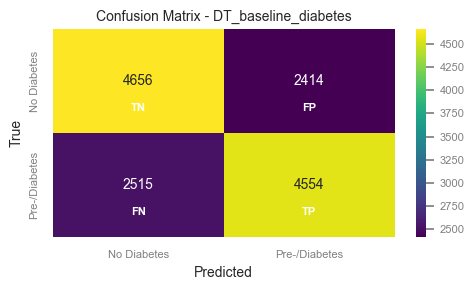


--- Generating Performance Curves ---


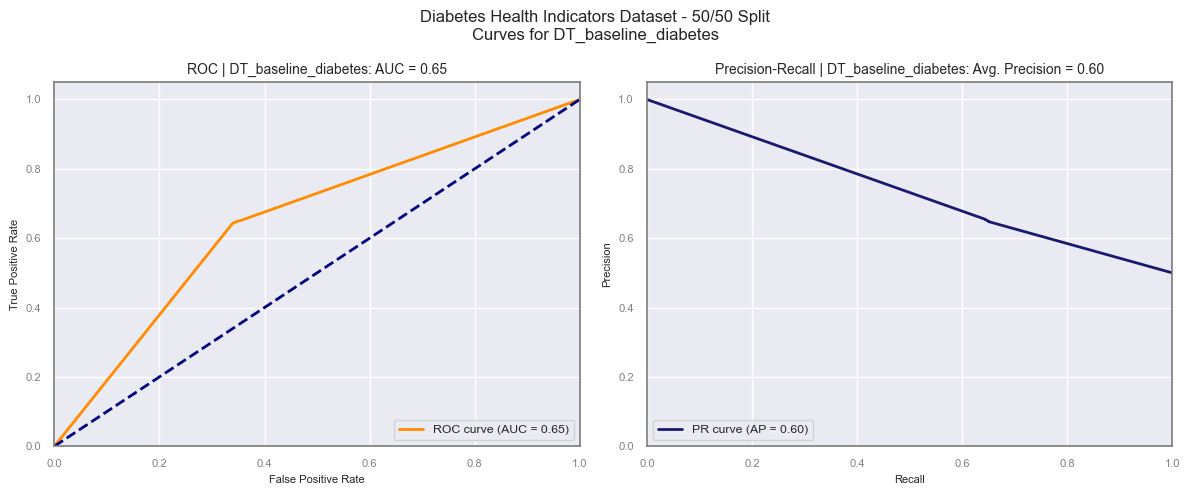

In [103]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize = (5, 3))

plot_confusion_matrix(
    y_test,
    diabetes_results_DT_baseline['y_pred'],
    model_name   = diabetes_results_DT_baseline['metrics']['model_name'],
    labels       = list(dict_outcome.values()),
    ax           = plt.gca()
)
plt.show()


# ---  Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 5))

# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3a}\nCurves for {diabetes_results_DT_baseline["metrics"]["model_name"]}', fontsize=12)
plot_roc_auc_curve(
    diabetes_results_DT_baseline['classifier'],
    X_test_final,
    y_test,
    title   = f'ROC | {diabetes_results_DT_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    diabetes_results_DT_baseline['classifier'],
    X_test_final,
    y_test,
    title   = f'Precision-Recall | {diabetes_results_DT_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

In [104]:
# results_DT_baseline['cv_results']

In [105]:
metrics_DT_baseline_df = pd.DataFrame(diabetes_results_DT_baseline['metrics'], index = [0])
metrics_DT_baseline_df

,model_name,execution_time_seconds,mean_cv_accuracy,mean_cv_precision,mean_cv_recall,mean_cv_f1,test_accuracy
0,DT_baseline_diabetes,00:00:02,0.656439,0.658028,0.651444,0.654697,0.65139


### Diabetes | DT w/GridSearchCV

In [106]:
# We use a broad range of depths to see if a simple tree performs better than the deep baseline.
# We also test different minimum leaf sizes to reduce noise and fragmentation.
diabetes_param_grid_DTC = {
    'max_depth':            [3, 5, 8, 12, 15, 20, None], # None means full depth (baseline)
    'min_samples_leaf':     [1, 5, 10, 20],
    'min_samples_split':    [2, 10, 20, 50], # Added min_samples_split
    'criterion':            ['gini', 'entropy']
}

Using GridSearchCV...
Fitting 5 folds for each of 224 candidates, totalling 1120 fits

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 50}
Best CV Score (f1): 0.7506
Test Accuracy: 0.7389
Execution Time: 00:00:21
Completed at: 2025-10-18 21:53:59

DecisionTreeClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

         0.0     0.7662    0.6878    0.7249      7070
         1.0     0.7168    0.7901    0.7516      7069

    accuracy                         0.7389     14139
   macro avg     0.7415    0.7390    0.7383     14139
weighted avg     0.7415    0.7389    0.7383     14139

Train Accuracy: 0.7533
Test Accuracy: 0.7389


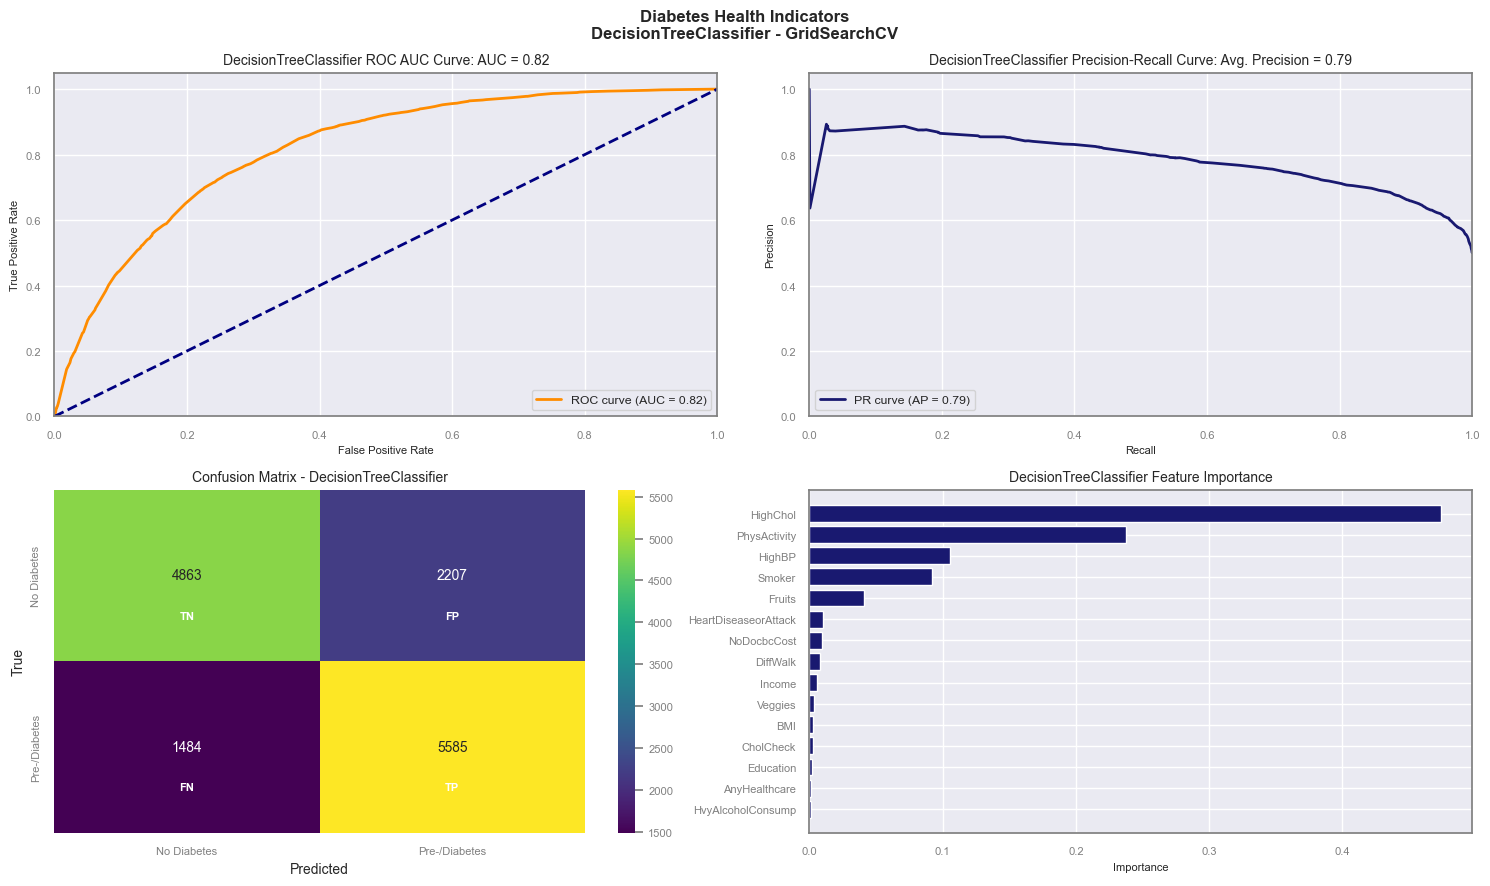

In [107]:
diabetes_DTC_gridsearch_results = run_GridSearch_RandomizedSearch_CV(
    model               = DecisionTreeClassifier,
    dataset_name       = 'Diabetes Health Indicators',
    parameter_grid     = diabetes_param_grid_DTC,
    X                  = X,
    X_train            = X_train_final,
    y_train            = y_train,
    X_test             = X_test_final,  
    y_test             = y_test,
    classification_dict= dict_outcome,
    CV_tuning_strategy = 2, # 0=Randomized, 1=HalvingGrid, 2=Grid
    is_classifier      = True,
    iterations         = 20, # Only used for RandomizedSearchCV
    n_jobs             = -1,
    verbose            = 1,
    cv_folds           = 5,
    random_state       = random_state,
    scoring_metric     = 'f1', # Balanced for binary classification
    halving_factor     = 2
)

params_diab_dtc_grid_df     = diabetes_DTC_gridsearch_results[0]
cv_results_diab_dtc_grid_df = diabetes_DTC_gridsearch_results[1]
grid_search_dtc             = diabetes_DTC_gridsearch_results[2]

### Diabetes | Random Forest: Baseline

In [108]:
RF_baseline_params_diabetes = {
    'n_estimators':         100,
    'criterion':            'gini',
    'max_features':         'sqrt', # Best practice for RF
    'max_depth':            None,
    'min_samples_split':    2,
    'min_samples_leaf':     1,
    'random_state':         random_state
}

In [109]:
results_RF_baseline_diabetes = run_random_forest_classifier(
    X_train             = X_train_final,
    y_train             = y_train,
    X_test              = X_test_final,
    y_test              = y_test,
    model_name          = 'Baseline Random Forest',
    dict_outcome        = dict_outcome,
    n_estimators        = RF_baseline_params_diabetes['n_estimators'],
    criterion           = RF_baseline_params_diabetes['criterion'],
    max_depth           = RF_baseline_params_diabetes['max_depth'],
    max_features        = RF_baseline_params_diabetes['max_features'],
    random_state        = RF_baseline_params_diabetes['random_state'],
    n_repeats           = 10 # Using 10 repeats for faster baseline check
)


--- Final Baseline Random Forest Evaluation ---
Final Test Accuracy: 0.7349

Confusion Matrix (Test Set)
                No Diabetes  Pre-/Diabetes
No Diabetes           4964           2106
Pre-/Diabetes         1642           5427 

Classification Report (Test Set)
               precision    recall  f1-score   support

  No Diabetes       0.75      0.70      0.73      7070
Pre-/Diabetes       0.72      0.77      0.74      7069

     accuracy                           0.73     14139
    macro avg       0.74      0.73      0.73     14139
 weighted avg       0.74      0.73      0.73     14139
 

Mean CV Accuracy: model correctly classifies ~ 0.7375 of instances across 50 different training-validation splits
Mean CV Precision: when  model predicts the positive class, it's correct ~ 0.7204 of the time.
Mean CV Recall: model correctly identifies ~ 0.7766 of all actual positive cases (True Positives).
Mean CV F1 Score:  the harmonic mean of precision and recall is 0.7474



--- Visualizing Confusion Matrix ---


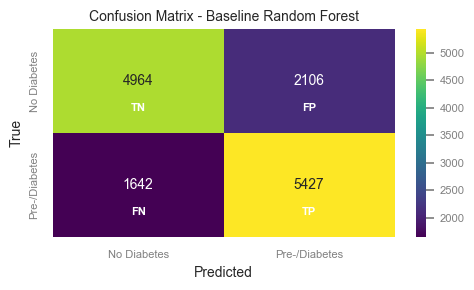


--- Generating Performance Curves ---


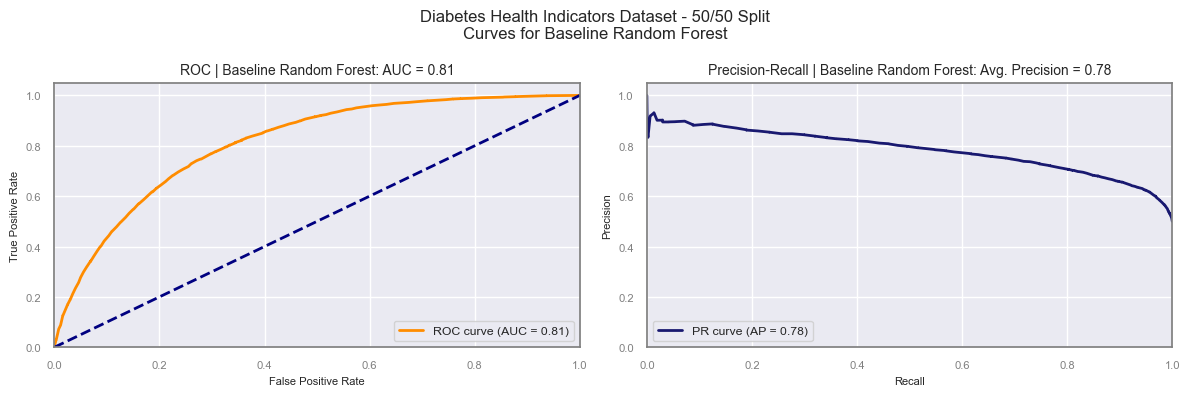

In [110]:
# : Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test,
    results_RF_baseline_diabetes['y_pred'],
    model_name   = results_RF_baseline_diabetes['metrics']['model_name'],
    labels       = list(dict_outcome.values()),
    ax           = plt.gca()
)
plt.show()


# --- 8. Model Visualization (ROC AUC and Precision-Recall) ---
print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 4))
plt.suptitle(f'{dataset_3a}\nCurves for {results_RF_baseline_diabetes["metrics"]["model_name"]}', fontsize=12)
# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plot_roc_auc_curve(
    results_RF_baseline_diabetes['classifier'],
    X_test_final,
    y_test,
    title   = f'ROC | {results_RF_baseline_diabetes["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    results_RF_baseline_diabetes['classifier'],
    X_test_final,
    y_test,
    title   = f'Precision-Recall | {results_RF_baseline_diabetes["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

### Diabetes | RF: GridSearchCV

Using GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score (f1): 0.7620
Test Accuracy: 0.7499
Execution Time: 00:01:59
Completed at: 2025-10-18 21:56:23

RandomForestClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

         0.0     0.7740    0.7061    0.7385      7070
         1.0     0.7297    0.7937    0.7604      7069

    accuracy                         0.7499     14139
   macro avg     0.7518    0.7499    0.7494     14139
weighted avg     0.7519    0.7499    0.7494     14139

Train Accuracy: 0.8218
Test Accuracy: 0.7499


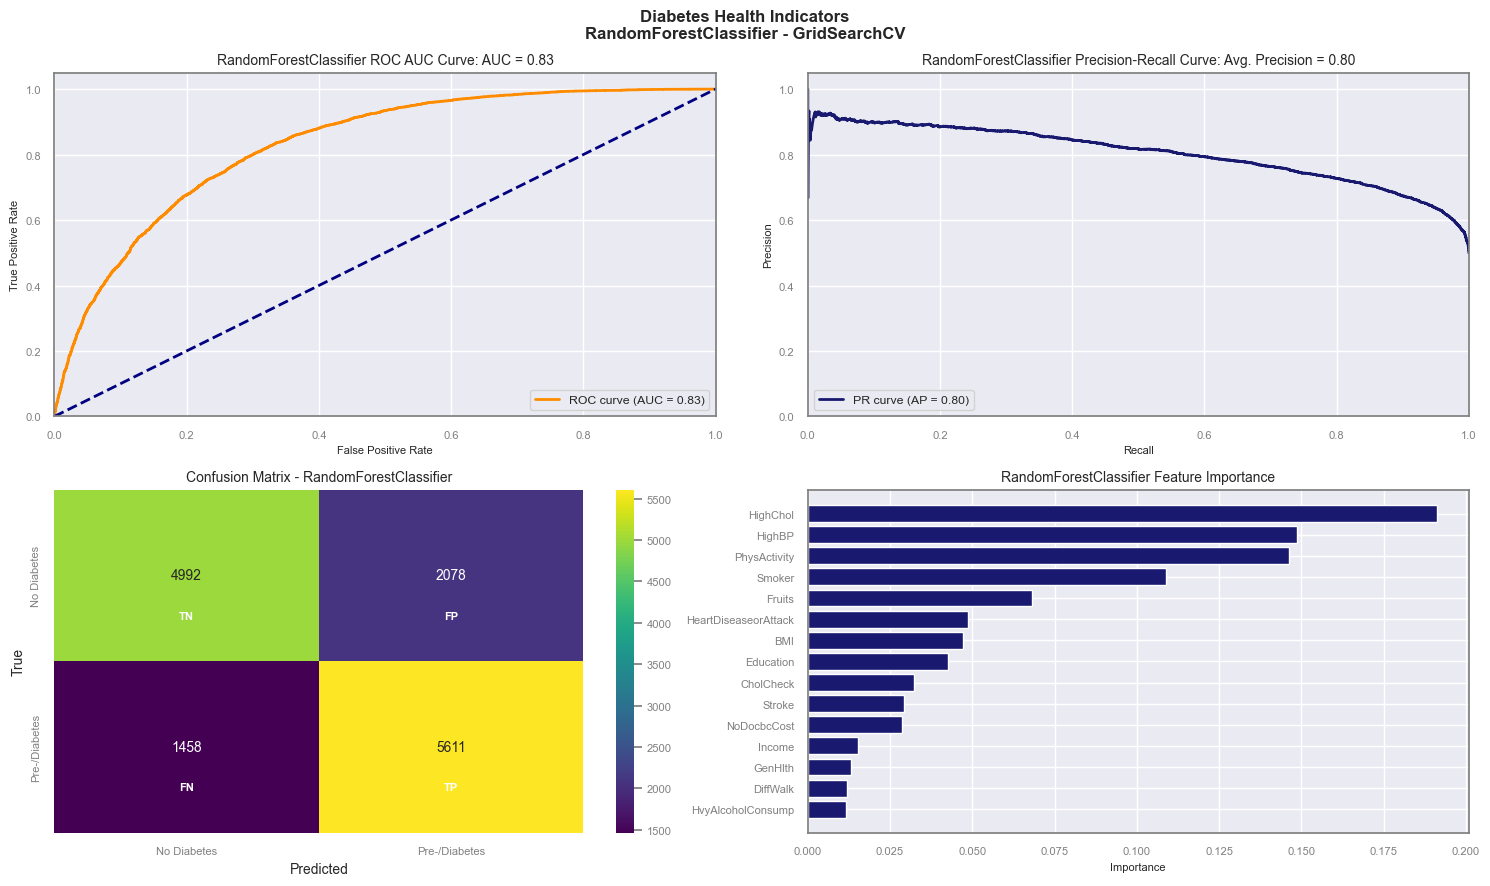

In [111]:
# Define the parameter grid for GridSearch
diabetes_parameter_grid_rf = {
    'n_estimators':         [50, 100, 200],         # Number of trees
    'max_depth':            [8, 15, None],          # Max depth of the tree
    'min_samples_split':    [5, 10],                # Minimum samples required to split a node
    'max_features':         ['sqrt', 0.5]           # Number of features to consider for best split
}

# Execute the GridSearch
diabetes_gridsearch_results = run_GridSearch_RandomizedSearch_CV(
    model                = RandomForestClassifier,
    dataset_name         = 'Diabetes Health Indicators',
    parameter_grid       = diabetes_parameter_grid_rf,
    X                    = X,                  # Full X for feature names
    X_train              = X_train_final,
    y_train              = y_train,
    X_test               = X_test_final,
    y_test               = y_test,
    classification_dict  = dict_outcome,
    CV_tuning_strategy   = 2,                  # 2 = GridSearchCV
    iterations           = 10,                 # Ignored by GridSearchCV
    n_jobs               = -1,
    verbose              = 1,                  # Set verbose to 1 to see progress
    cv_folds             = 5,
    scoring_metric       = 'f1',               # Optimizing for F1-score
    random_state         = random_state
)


params_diab_RF_grid_df     = diabetes_gridsearch_results[0]
cv_results_diab_RF_grid_df = diabetes_gridsearch_results[1]
grid_search_diabetes_RF    = diabetes_gridsearch_results[2]

In [130]:
cv_results_diab_RF_grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.158831,0.011980,0.090077,0.029314,8,sqrt,5,50,"{'model__max_depth': 8, 'model__max_features':...",0.761743,...,0.759193,0.003453,13,0.769526,0.769250,0.770660,0.767353,0.769462,0.769250,0.001069
1,2.325635,0.058108,0.112246,0.009477,8,sqrt,5,100,"{'model__max_depth': 8, 'model__max_features':...",0.761118,...,0.759286,0.002725,10,0.768905,0.769701,0.771562,0.767854,0.769932,0.769591,0.001225
2,4.462266,0.087982,0.204243,0.012022,8,sqrt,5,200,"{'model__max_depth': 8, 'model__max_features':...",0.761435,...,0.759511,0.002055,7,0.769218,0.770514,0.771933,0.768953,0.770091,0.770142,0.001060
3,1.098743,0.027891,0.055443,0.002003,8,sqrt,10,50,"{'model__max_depth': 8, 'model__max_features':...",0.760698,...,0.759069,0.002332,15,0.768831,0.767899,0.771299,0.767571,0.770079,0.769136,0.001388
4,2.345457,0.029397,0.101116,0.006366,8,sqrt,10,100,"{'model__max_depth': 8, 'model__max_features':...",0.759436,...,0.759150,0.002455,14,0.769582,0.768904,0.771062,0.767738,0.769976,0.769452,0.001106
5,4.359803,0.109995,0.199659,0.010932,8,sqrt,10,200,"{'model__max_depth': 8, 'model__max_features':...",0.761306,...,0.759338,0.002407,9,0.769855,0.768715,0.771004,0.768685,0.770452,0.769742,0.000925
6,2.122123,0.037423,0.054682,0.004765,8,0.5,5,50,"{'model__max_depth': 8, 'model__max_features':...",0.759061,...,0.759026,0.000754,16,0.774860,0.773964,0.773869,0.773683,0.774931,0.774261,0.000526
7,4.133293,0.060249,0.109410,0.004212,8,0.5,5,100,"{'model__max_depth': 8, 'model__max_features':...",0.759390,...,0.759285,0.001161,11,0.775042,0.774298,0.774551,0.774611,0.774745,0.774649,0.000244
8,8.206685,0.048266,0.204995,0.011236,8,0.5,5,200,"{'model__max_depth': 8, 'model__max_features':...",0.759908,...,0.759524,0.001072,6,0.774260,0.773637,0.775251,0.774099,0.774791,0.774408,0.000560
9,2.077001,0.027538,0.061852,0.003061,8,0.5,10,50,"{'model__max_depth': 8, 'model__max_features':...",0.755768,...,0.758423,0.002176,21,0.773189,0.773203,0.773472,0.773180,0.774172,0.773443,0.000380


##  <font color='plum'> 3.b. Hypertension Risk Prediction Dataset

Includes lifestyle, demographic, and clinical data (e.g., BMI, cholesterol, stress,
salt intake, smoking, family history) from individuals across multiple countries. It is
labeled for classification tasks (low vs. high risk of hypertension).
https://www.kaggle.com/datasets/ankushpanday1/hypertension-risk-prediction-dataset

### Load & Clean

In [112]:

# file_path = "ankushpanday1/hypertension-risk-prediction-dataset"
# file_name = "hypertension_dataset.csv"

# df_3b = kagglehub.dataset_load(
#   KaggleDatasetAdapter.PANDAS,
#   file_path,
#   file_name,
# )
# df_3b.columns = df_3b.columns.str.strip() 
# print(df_3b.shape)
# df_3b.head()

In [113]:
# # pandas plot of 'Hypertension' column
# df_3b['Hypertension'].value_counts().plot(kind='bar', title='Hypertension Distribution', xlabel='Hypertension', ylabel='Count', color=['blue', 'orange'])
# plt.show()

<font color='plum'>

- This is an extremely imbalanced dataset, which isn't helping matters. The model will always favor the majority class to optimize accuracy at expense of minority class

- Will explore 'f1' or 'recall' in RandomizedSearchCV to force the model to optimize for minority class performance.


In [114]:
# target_col          = 'Hypertension'
# categorical_cols    = ['Country', 'Smoking_Status', 'Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level', 'Employment_Status', 'Hypertension']
# numeric_cols        = ['Age', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP', 'Alcohol_Intake', 'Stress_Level', 'Salt_Intake', 'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides', 'Glucose']
# len(categorical_cols), len(numeric_cols)

# # for col in categorical_cols:
# #     print(f'{col}: {df_3b[col].unique()},\n{df_3b[col].nunique()} unique values\n')

In [115]:
# data = df_3b.copy()

# # Dropping 'Country' column because it's fucking pointless for this analysis 
# data = data.drop(columns = ['Country'])

# # One-hot encode 'Smoking_Status', and 'Employment_Status' columns
# data = pd.get_dummies(data, columns = ['Smoking_Status', 'Employment_Status'], drop_first = True)

# cat_cols_2 = ['Physical_Activity_Level', 'Family_History', 'Diabetes', 'Gender', 'Education_Level']

# for col in cat_cols_2:
#     data[col] = LabelEncoder().fit_transform(data[col])

# # for target column, map 'High' to 1, 'Low' to 0
# data[target_col] = data[target_col].map({'High': 1, 'Low': 0})
# data.head()

# #export data to csv
# # data.to_csv('hypertension_dataset_processed.csv', index=False)


In [116]:
# random_state        = 42
# test_size           = 0.2

# y = data[target_col]
# X = data.drop(columns = [target_col])

## <font color='plum'> 3.c. Chronic Kidney Disease Dataset

Contains comprehensive data for 1,659 patients, including 54 variables spanning medical history, lab results, medication usage, quality of life, and environmental
exposure. Ideal for regression, classification, and clustering analyses.
https://www.kaggle.com/datasets/rabieelkharoua/chronic-kidney-disease-dataset-analysis

### Load & Clean - CKD

In [117]:
file_path  = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name  = "Chronic_Kidney_Dsease_data.csv"
dataset_3c = 'Chronic Kidney Disease Prediction'

# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']
df_3c.drop(columns  = columns_to_drop, inplace = True, errors = 'ignore')

# for stupid confusion matrix plot
classification_dict_CKD = {
    0: 'No CKD',
    1: 'CKD'
}

X_train_CKD, X_test_CKD, y_train_CKD, y_test_CKD, X_CKD = prepare_data(
    df              = df_3c,
    target_col      = 'Diagnosis',
    test_size       = test_size,
    random_state    = random_state
)


print("X_train:", X_train_CKD.shape)
print("y_train:", y_train_CKD.shape)
print("X_test:", X_test_CKD.shape)
print("y_test:", y_test_CKD.shape)


Target variable 'Diagnosis' encoded successfully.
Dropped rows with NaNs. Initial rows: 1659, Final rows: 1659
Percentage of data retained: 100.00%

Applied robust data type coercion to feature columns.
Data Split: Training set size = 1327, Test set size = 332

--- Manual Feature Scaling ---
Scaling Complete.

X_train: (1327, 51)
y_train: (1327,)
X_test: (332, 51)
y_test: (332,)


### CKD | DT Clsssifier: Baseline 

In [118]:
results_CKD_DT_baseline = run_decision_tree_classifier(X_train_CKD, 
                                                        y_train_CKD, 
                                                        X_test_CKD,
                                                        y_test_CKD,
                                                        model_name   = 'CKD_DT_baseline', 
                                                        dict_outcome = classification_dict_CKD, 
                                                        visualize    = False
                                                   )


--- Final CKD_DT_baseline Evaluation ---
Final Test Accuracy: 0.8584

Confusion Matrix (Test Set)
         No CKD  CKD
No CKD       8   19
CKD         28  277 

Classification Report (Test Set)
              precision    recall  f1-score   support

      No CKD       0.22      0.30      0.25        27
         CKD       0.94      0.91      0.92       305

    accuracy                           0.86       332
   macro avg       0.58      0.60      0.59       332
weighted avg       0.88      0.86      0.87       332
 

Mean CV Accuracy: model correctly classifies ~ 0.8762 of instances across 25 different training-validation splits
Mean CV Precision: when  model predicts the positive class, it's correct ~ 0.9372 of the time.
Mean CV Recall: model correctly identifies ~ 0.9275 of all actual positive cases (True Positives).
Mean CV F1 Score:  the harmonic mean of precision and recall is 0.9321



--- Visualizing Confusion Matrix ---


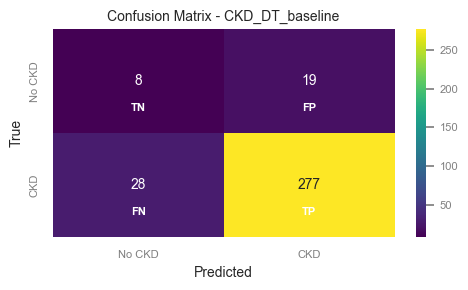


--- Generating Performance Curves ---


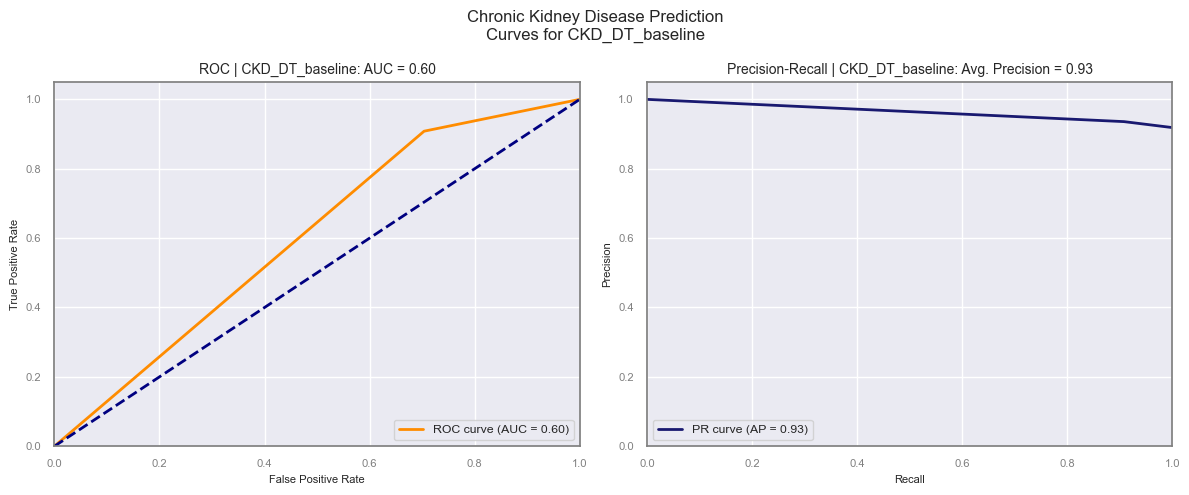

In [119]:
# VISUALIZATION: Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test_CKD,
    results_CKD_DT_baseline['y_pred'],
    model_name   = results_CKD_DT_baseline['metrics']['model_name'],
    labels       = list(classification_dict_CKD.values()),
    ax           = plt.gca()
)
plt.show()


# --- 8. Model Visualization (ROC AUC and Precision-Recall) ---

print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 5))

# Plot 1: ROC AUC Curve using the enhanced function
plt.suptitle(f'{dataset_3c}\nCurves for {results_CKD_DT_baseline["metrics"]["model_name"]}', fontsize=12)
plt.subplot(1, 2, 1)
plot_roc_auc_curve(
    results_CKD_DT_baseline['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'ROC | {results_CKD_DT_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    results_CKD_DT_baseline['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'Precision-Recall | {results_CKD_DT_baseline["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

### CKD | DT Classifier w/ GridSearchCV

In [120]:
param_grid_CKD_DTC = {
    'max_depth': [3, 5, 8, 12, 15, 20, None], # None means full depth (baseline)
    'min_samples_leaf': [1, 5, 10, 20],
    'min_samples_split': [2, 10, 20, 50], # Added min_samples_split
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

Using GridSearchCV...
Fitting 5 folds for each of 448 candidates, totalling 2240 fits



Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best CV Score (f1_macro): 0.6579
Test Accuracy: 0.9066
Execution Time: 00:00:07
Completed at: 2025-10-18 21:56:34

DecisionTreeClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     0.3750    0.2222    0.2791        27
           1     0.9335    0.9672    0.9501       305

    accuracy                         0.9066       332
   macro avg     0.6543    0.5947    0.6146       332
weighted avg     0.8881    0.9066    0.8955       332

Train Accuracy: 0.9495
Test Accuracy: 0.9066


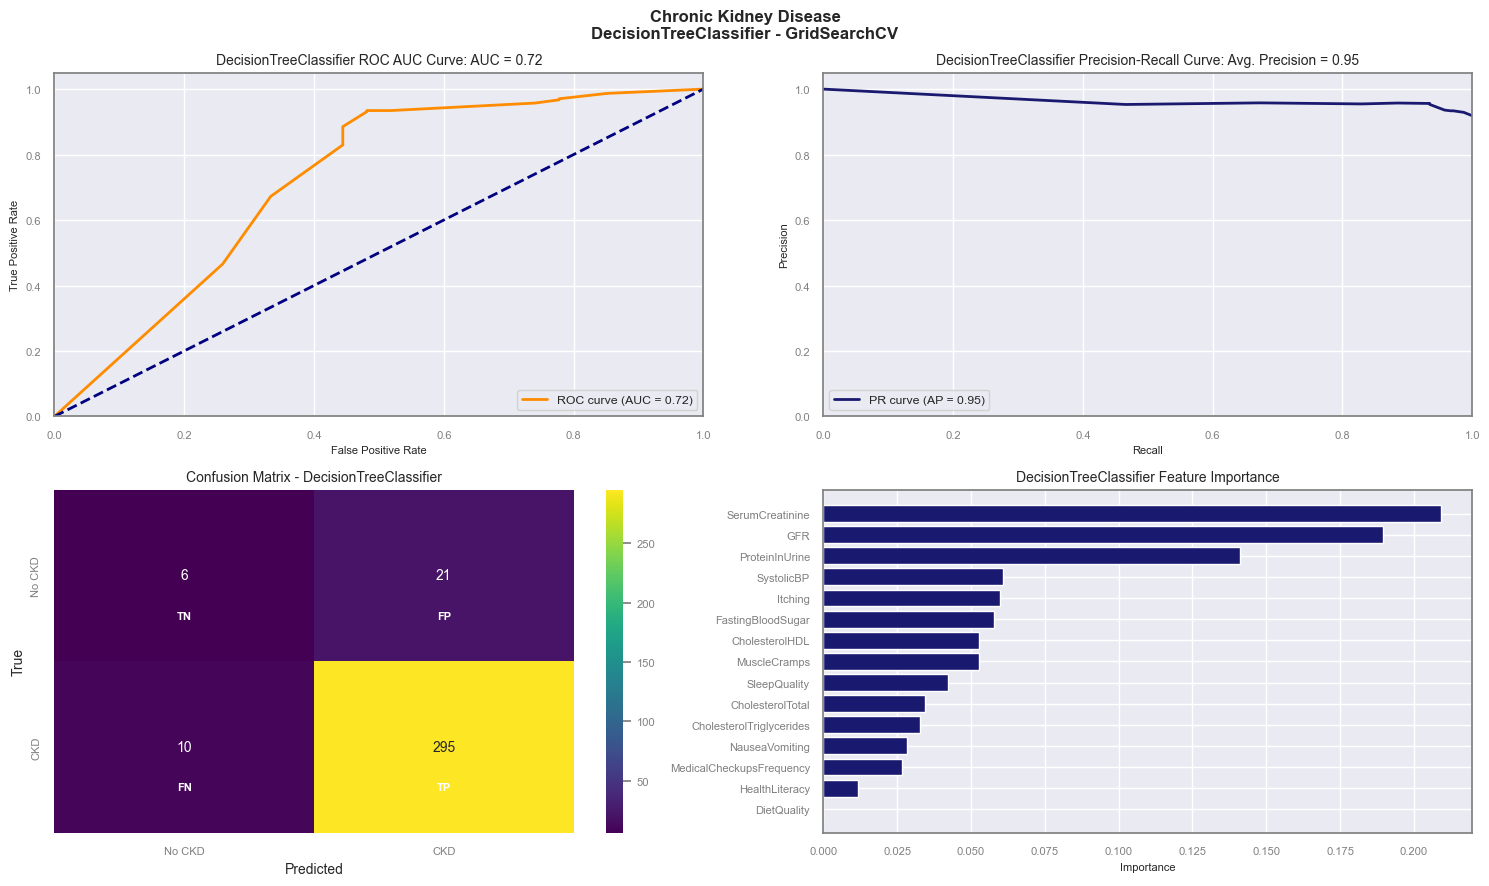

In [121]:
CKD_dtc_gridsearch_results = run_GridSearch_RandomizedSearch_CV(
    model                   = DecisionTreeClassifier,
    dataset_name            = "Chronic Kidney Disease",
    parameter_grid          = param_grid_CKD_DTC,
    X                       = X_CKD,
    X_train                 = X_train_CKD,
    y_train                 = y_train_CKD,
    X_test                  = X_test_CKD,
    y_test                  = y_test_CKD,
    classification_dict     = classification_dict_CKD,
    CV_tuning_strategy      = 2,
    is_classifier           = True,
    iterations              = 30,
    n_jobs                  = -1,
    verbose                 = 1,
    cv_folds                = 5,
    random_state            = 42,
    scoring_metric          = 'f1_macro', # penalizes the macro score for minority misclassifications
    halving_factor          = 2
)

params_CKD_dtc_grid_df     = CKD_dtc_gridsearch_results[0]
cv_results_CKD_dtc_grid_df = CKD_dtc_gridsearch_results[1]
grid_search_CKD_dtc        = CKD_dtc_gridsearch_results[2]

In [122]:
params_CKD_dtc_grid_df

,class_weight,criterion,max_depth,min_samples_leaf,min_samples_split,Dataset,Model,Strategy,Scoring_Metric,Best_CV_Score,Test_Accuracy,execution_time,timestamp
0,None,entropy,5,5,20,Chronic Kidney Disease,DecisionTreeClassifier,GridSearchCV,f1_macro,0.657894,0.906627,00:00:07,2025-10-18 21:56:34


In [128]:
cv_results_CKD_dtc_grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__class_weight,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013570,0.000728,0.002393,0.000633,None,gini,3,1,2,"{'model__class_weight': None, 'model__criterio...",...,0.614286,0.048177,203,0.721393,0.717261,0.787365,0.662545,0.696829,0.717079,0.040848
1,0.013734,0.000604,0.002559,0.000788,None,gini,3,1,10,"{'model__class_weight': None, 'model__criterio...",...,0.614286,0.048177,203,0.721393,0.717261,0.787365,0.662545,0.696829,0.717079,0.040848
2,0.014536,0.000544,0.002708,0.000870,None,gini,3,1,20,"{'model__class_weight': None, 'model__criterio...",...,0.614286,0.048177,203,0.721393,0.717261,0.787365,0.662545,0.696829,0.717079,0.040848
3,0.014617,0.001241,0.002695,0.000698,None,gini,3,1,50,"{'model__class_weight': None, 'model__criterio...",...,0.607033,0.048265,263,0.668170,0.717261,0.762120,0.662545,0.696829,0.701385,0.036258
4,0.013905,0.000259,0.002575,0.000861,None,gini,3,5,2,"{'model__class_weight': None, 'model__criterio...",...,0.617316,0.049634,177,0.709010,0.705005,0.776602,0.654852,0.690505,0.707195,0.039607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,0.027823,0.001798,0.002790,0.000790,balanced,entropy,None,10,50,"{'model__class_weight': 'balanced', 'model__cr...",...,0.575652,0.029686,401,0.726848,0.714020,0.709750,0.697577,0.710823,0.711804,0.009368
444,0.027868,0.004192,0.003141,0.000494,balanced,entropy,None,20,2,"{'model__class_weight': 'balanced', 'model__cr...",...,0.583709,0.032472,365,0.695098,0.747958,0.739934,0.737261,0.703683,0.724787,0.021207
445,0.024697,0.001089,0.002246,0.000250,balanced,entropy,None,20,10,"{'model__class_weight': 'balanced', 'model__cr...",...,0.583709,0.032472,365,0.695098,0.747958,0.739934,0.737261,0.703683,0.724787,0.021207
446,0.025358,0.002353,0.002354,0.000451,balanced,entropy,None,20,20,"{'model__class_weight': 'balanced', 'model__cr...",...,0.583709,0.032472,365,0.695098,0.747958,0.739934,0.737261,0.703683,0.724787,0.021207


No CKD F1-score (Minority)	0.2791	This confirms the model is still ineffective at identifying healthy patients, despite optimizing for the macro F1 score.

### CKD | Random Forest Classifier: Baseline

In [124]:
RF_baseline_params_CKD = {
    'n_estimators':         100,
    'criterion':            'gini',
    'max_features':         'sqrt', # Best practice for RF
    'max_depth':            None,
    'min_samples_split':    2,
    'min_samples_leaf':     1,
    'random_state':         random_state
}

In [125]:
results_RF_baseline_CKD = run_random_forest_classifier(
    X_train             = X_train_CKD,
    y_train             = y_train_CKD,
    X_test              = X_test_CKD,
    y_test              = y_test_CKD,
    model_name          = 'Baseline Random Forest',
    dict_outcome        = classification_dict_CKD,
    n_estimators        = RF_baseline_params_CKD['n_estimators'],
    criterion           = RF_baseline_params_CKD['criterion'],
    max_depth           = RF_baseline_params_CKD['max_depth'],
    max_features        = RF_baseline_params_CKD['max_features'],
    random_state        = RF_baseline_params_CKD['random_state'],
    n_repeats           = 10 # Using 10 repeats for faster baseline check
)


--- Final Baseline Random Forest Evaluation ---
Final Test Accuracy: 0.9217

Confusion Matrix (Test Set)
         No CKD  CKD
No CKD       1   26
CKD          0  305 

Classification Report (Test Set)
              precision    recall  f1-score   support

      No CKD       1.00      0.04      0.07        27
         CKD       0.92      1.00      0.96       305

    accuracy                           0.92       332
   macro avg       0.96      0.52      0.52       332
weighted avg       0.93      0.92      0.89       332
 

Mean CV Accuracy: model correctly classifies ~ 0.9193 of instances across 50 different training-validation splits
Mean CV Precision: when  model predicts the positive class, it's correct ~ 0.9192 of the time.
Mean CV Recall: model correctly identifies ~ 1.0000 of all actual positive cases (True Positives).
Mean CV F1 Score:  the harmonic mean of precision and recall is 0.9579



--- Visualizing Confusion Matrix ---


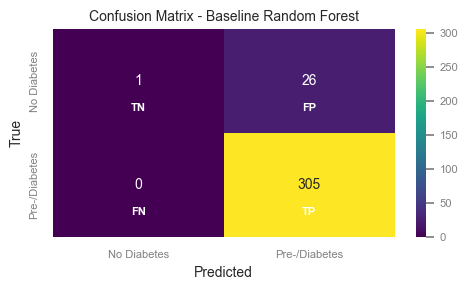


--- Generating Performance Curves ---


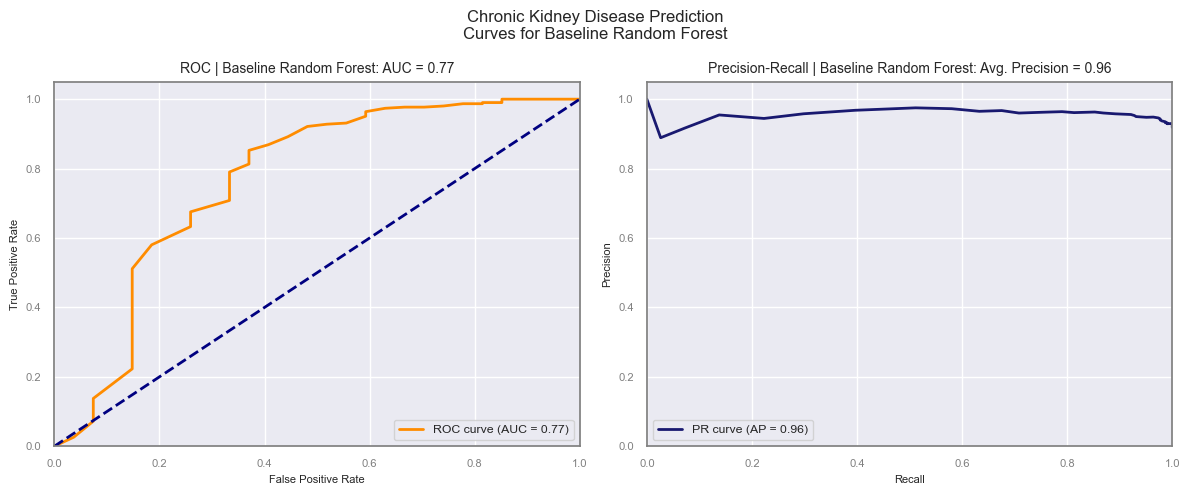

In [126]:
# : Confusion Matrix
print("\n--- Visualizing Confusion Matrix ---")
plt.figure(figsize=(5, 3))
plot_confusion_matrix(
    y_test_CKD,
    results_RF_baseline_CKD['y_pred'],
    model_name   = results_RF_baseline_CKD['metrics']['model_name'],
    labels       = list(dict_outcome.values()),
    ax           = plt.gca()
)
plt.show()


# --- 8. Model Visualization (ROC AUC and Precision-Recall) ---
print("\n--- Generating Performance Curves ---")

plt.figure(figsize = (12, 5))

# Plot 1: ROC AUC Curve using the enhanced function
plt.subplot(1, 2, 1)
plt.suptitle(f'{dataset_3c}\nCurves for {results_RF_baseline_CKD["metrics"]["model_name"]}', fontsize=12)
plot_roc_auc_curve(
    results_RF_baseline_CKD['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'ROC | {results_RF_baseline_CKD["metrics"]["model_name"]}',
    ax      = plt.gca()
)

# Plot 2: Precision-Recall curve using the enhanced function
plt.subplot(1, 2, 2)
plot_precision_recall_curve(
    results_RF_baseline_CKD['classifier'],
    X_test_CKD,
    y_test_CKD,
    title   = f'Precision-Recall | {results_RF_baseline_CKD["metrics"]["model_name"]}',
    ax      = plt.gca()
)

plt.tight_layout()
plt.show()

### CKD | Random Forest Classifier: GridSearchCV

Using GridSearchCV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 0.5, 'min_samples_leaf': 4, 'n_estimators': 100}
Best CV Score (f1_macro): 0.6504
Test Accuracy: 0.9096
Execution Time: 00:01:23
Completed at: 2025-10-18 21:58:00

RandomForestClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     0.3846    0.1852    0.2500        27
           1     0.9310    0.9738    0.9519       305

    accuracy                         0.9096       332
   macro avg     0.6578    0.5795    0.6010       332
weighted avg     0.8866    0.9096    0.8948       332

Train Accuracy: 0.9992
Test Accuracy: 0.9096


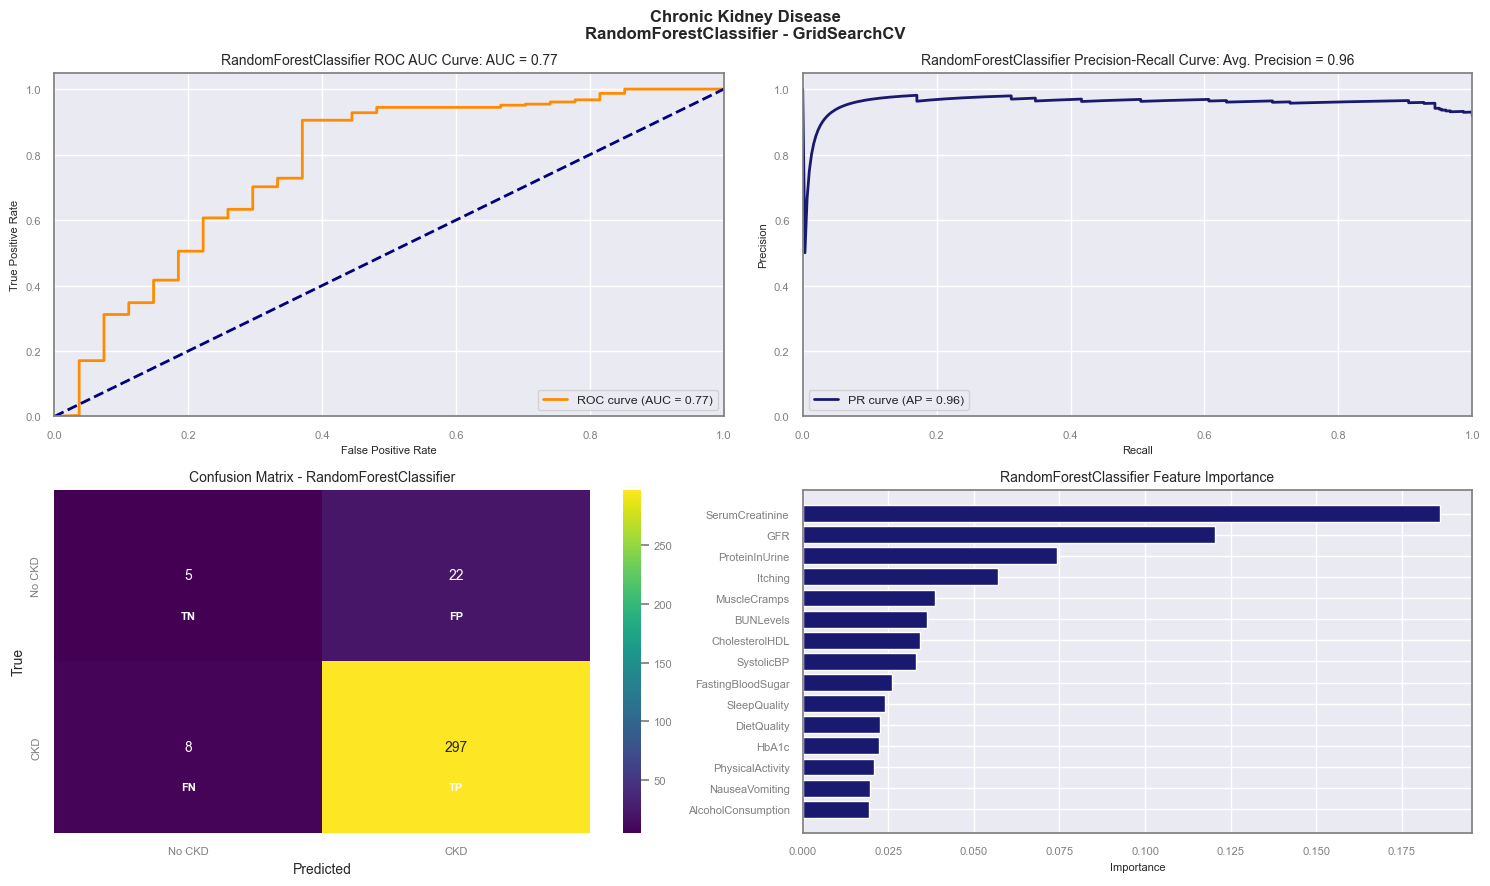

In [127]:
# Define the parameter grid for GridSearch
CKD_parameter_grid_rf = {
    'n_estimators':         [100, 250, 400],         # Number of trees
    'max_depth':            [12, 18, None],          # Max depth of the tree
    'min_samples_leaf':     [1, 2, 4],                # Minimum samples required to split a node
    'max_features':         ['sqrt', 0.5],           # Number of features to consider for best split
    'class_weight':         [None, 'balanced']
}

# Execute the GridSearch
CKD_gridsearch_results = run_GridSearch_RandomizedSearch_CV(
    model                = RandomForestClassifier,
    dataset_name         = 'Chronic Kidney Disease',
    parameter_grid       = CKD_parameter_grid_rf,
    X                    = X_CKD,                  # Full X for feature names
    X_train              = X_train_CKD,
    y_train              = y_train_CKD,
    X_test               = X_test_CKD,
    y_test               = y_test_CKD,
    classification_dict  = classification_dict_CKD,
    CV_tuning_strategy   = 2,                  # 2 = GridSearchCV
    iterations           = 10,                 # Ignored by GridSearchCV
    n_jobs               = -1,
    verbose              = 1,                  # Set verbose to 1 to see progress
    cv_folds             = 5,
    scoring_metric       = 'f1_macro',               # Optimizing for F1-score
    random_state         = random_state
)


params_CKD_RF_grid_df     = CKD_gridsearch_results[0]
cv_results_CKD_RF_grid_df = CKD_gridsearch_results[1]
grid_search_CKD_RF        = CKD_gridsearch_results[2]

In [129]:
cv_results_CKD_RF_grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__class_weight,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.394761,0.003419,0.008535,0.002168,None,12,sqrt,1,100,"{'model__class_weight': None, 'model__max_dept...",...,0.496558,0.021436,65,0.996820,0.996820,0.993674,1.000000,1.000000,0.997463,0.002369
1,1.057551,0.048926,0.017052,0.003547,None,12,sqrt,1,250,"{'model__class_weight': None, 'model__max_dept...",...,0.487674,0.017593,72,1.000000,1.000000,0.993674,1.000000,1.000000,0.998735,0.002530
2,1.763279,0.057913,0.020918,0.002307,None,12,sqrt,1,400,"{'model__class_weight': None, 'model__max_dept...",...,0.478790,0.000475,83,1.000000,1.000000,0.993674,1.000000,1.000000,0.998735,0.002530
3,0.436379,0.032925,0.012726,0.005165,None,12,sqrt,2,100,"{'model__class_weight': None, 'model__max_dept...",...,0.478790,0.000475,83,0.929134,0.925136,0.926045,0.926045,0.940844,0.929441,0.005860
4,0.946403,0.024948,0.013247,0.002097,None,12,sqrt,2,250,"{'model__class_weight': None, 'model__max_dept...",...,0.478790,0.000475,83,0.921089,0.929134,0.929989,0.945298,0.936990,0.932500,0.008146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.887187,0.024979,0.014725,0.002499,balanced,None,0.5,2,250,"{'model__class_weight': 'balanced', 'model__ma...",...,0.595873,0.035587,25,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
104,3.119455,0.047219,0.019101,0.002501,balanced,None,0.5,2,400,"{'model__class_weight': 'balanced', 'model__ma...",...,0.594744,0.035490,28,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
105,0.767197,0.056778,0.008684,0.001884,balanced,None,0.5,4,100,"{'model__class_weight': 'balanced', 'model__ma...",...,0.650435,0.016759,1,0.996853,1.000000,0.990755,0.993805,0.996820,0.995647,0.003134
106,1.888269,0.086754,0.012705,0.001328,balanced,None,0.5,4,250,"{'model__class_weight': 'balanced', 'model__ma...",...,0.646435,0.023792,4,0.996853,1.000000,0.990755,0.993740,1.000000,0.996270,0.003605


### CKD | BalancedRandomForest Classifier : GridSearchCV

Using GridSearchCV...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best Parameters: {'class_weight': None, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
Best CV Score (f1_macro): 0.7405
Test Accuracy: 0.8825
Execution Time: 00:00:47
Completed at: 2025-10-18 22:34:24

BalancedRandomForestClassifier - GridSearchCV
Classification Report:
              precision    recall  f1-score   support

           0     0.3571    0.5556    0.4348        27
           1     0.9586    0.9115    0.9345       305

    accuracy                         0.8825       332
   macro avg     0.6579    0.7335    0.6846       332
weighted avg     0.9097    0.8825    0.8938       332

Train Accuracy: 0.9721
Test Accuracy: 0.8825


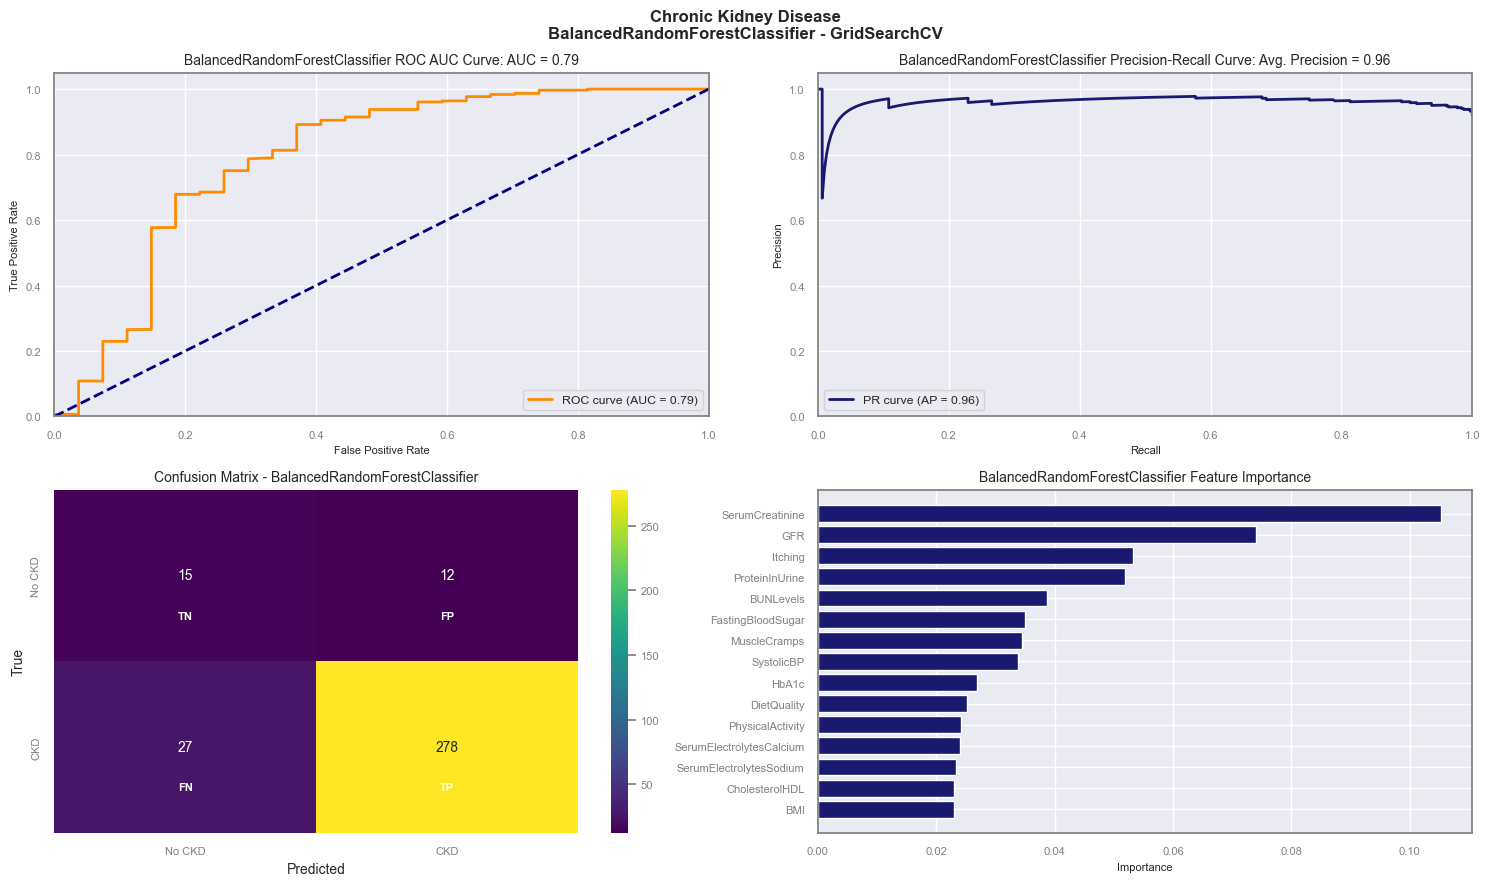

In [132]:
# Define the parameter grid for GridSearch
CKD_parameter_grid_rf = {
    'n_estimators':         [100, 250, 400],         # Number of trees
    'max_depth':            [6, 12, 18, None],          # Max depth of the tree
    'min_samples_leaf':     [1, 2, 4],                # Minimum samples required to split a node
    'max_features':         ['sqrt', 0.5],           # Number of features to consider for best split
    'class_weight':         [None, 'balanced']
}

# Execute the GridSearch
CKD_gridsearch_results = run_GridSearch_RandomizedSearch_CV(
    model                = BalancedRandomForestClassifier,
    dataset_name         = 'Chronic Kidney Disease',
    parameter_grid       = CKD_parameter_grid_rf,
    X                    = X_CKD,                  # Full X for feature names
    X_train              = X_train_CKD,
    y_train              = y_train_CKD,
    X_test               = X_test_CKD,
    y_test               = y_test_CKD,
    classification_dict  = classification_dict_CKD,
    CV_tuning_strategy   = 2,                  # 2 = GridSearchCV
    iterations           = 10,                 # Ignored by GridSearchCV
    n_jobs               = -1,
    verbose              = 1,                  # Set verbose to 1 to see progress
    cv_folds             = 5,
    scoring_metric       = 'f1_macro',               # Optimizing for F1-score
    random_state         = random_state
)


params_CKD_BRF_grid_df     = CKD_gridsearch_results[0]
cv_results_CKD_BRF_grid_df = CKD_gridsearch_results[1]

In [133]:
cv_results_CKD_BRF_grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__class_weight,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.188259,0.006559,0.008457,0.001419,None,6,sqrt,1,100,"{'model__class_weight': None, 'model__max_dept...",...,0.706095,0.029669,26,0.884502,0.890863,0.899597,0.921023,0.904067,0.900010,0.012509
1,0.477384,0.019386,0.014385,0.001351,None,6,sqrt,1,250,"{'model__class_weight': None, 'model__max_dept...",...,0.726302,0.020934,22,0.886606,0.915568,0.925148,0.933163,0.922723,0.916642,0.016035
2,0.756839,0.055704,0.019876,0.003897,None,6,sqrt,1,400,"{'model__class_weight': None, 'model__max_dept...",...,0.730485,0.020440,13,0.904057,0.922716,0.918658,0.951100,0.932551,0.925817,0.015614
3,0.192049,0.004333,0.006235,0.001001,None,6,sqrt,2,100,"{'model__class_weight': None, 'model__max_dept...",...,0.714216,0.027711,25,0.877303,0.887799,0.875267,0.923409,0.897390,0.892233,0.017487
4,0.527692,0.025159,0.014861,0.004909,None,6,sqrt,2,250,"{'model__class_weight': None, 'model__max_dept...",...,0.730830,0.025004,10,0.895189,0.900967,0.915577,0.938172,0.915577,0.913096,0.014892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.970149,0.031514,0.015585,0.001144,balanced,None,0.5,2,250,"{'model__class_weight': 'balanced', 'model__ma...",...,0.604696,0.027213,84,0.747820,0.765663,0.794859,0.768375,0.756624,0.766668,0.015842
140,1.547301,0.018383,0.019420,0.001440,balanced,None,0.5,2,400,"{'model__class_weight': 'balanced', 'model__ma...",...,0.603556,0.023711,85,0.740534,0.763037,0.797814,0.767054,0.755353,0.764758,0.018847
141,0.326054,0.011764,0.008000,0.001995,balanced,None,0.5,4,100,"{'model__class_weight': 'balanced', 'model__ma...",...,0.539585,0.018617,105,0.615787,0.633559,0.680217,0.646765,0.619844,0.639235,0.023213
142,0.826168,0.039971,0.014173,0.002670,balanced,None,0.5,4,250,"{'model__class_weight': 'balanced', 'model__ma...",...,0.548782,0.020109,100,0.630262,0.636051,0.689932,0.634960,0.624655,0.643172,0.023724



## ✅ Model Performance Assessment (Decision Tree & Random Forest)

 Performance of Decision Tree (DT) and Random Forest (RF) models on two distinct classification problems: a **balanced** Diabetes Health Indicators Dataset and a **highly imbalanced** Chronic Kidney Disease (CKD) Dataset.

## 1. Diabetes Health Indicators Dataset (Balanced)

This dataset presents a **balanced 50/50 split** between the target classes ('No Diabetes' vs. 'Pre-/Diabetes').

### Summary of Results (Diabetes)

| Model | Best CV F1 Score | Test Accuracy | Best Parameters |
| :--- | :--- | :--- | :--- |
| **Decision Tree (DT) Baseline** | 0.6547 | 0.6514 | Full depth (`max_depth=None`)|
| **DT w/ GridSearchCV** | 0.7506 | 0.7389 | `criterion='gini'`, `max_depth=8`, `min_samples_leaf=5`, `min_samples_split=50`|
| **Random Forest (RF) Baseline** | 0.7474 | 0.7349 | Full depth (`max_depth=None`), `n_estimators=100`|
| **RF w/ GridSearchCV** | **0.7620** | **0.7499** | `max_depth=15`, `max_features=0.5`, `min_samples_split=10`, `n_estimators=200`|

### Interpretation of Results (Diabetes)

* **Overfitting Management (DT):** The initial DT model was likely severely **overfitted** (low Test Accuracy: 65.14%). Tuning corrected this by choosing a constrained tree (`max_depth=8`), resulting in a substantial 10-percentage-point increase in performance.

* **Random Forest Advantage:** The **RF Baseline** performed significantly better than the DT baseline (73.49% vs. 65.14%). This confirms that ensemble methods effectively **reduce variance** (overfitting) by averaging the results of multiple trees.

* **Conclusion:** The **RF with GridSearchCV** is the best model for this balanced dataset, achieving the highest overall F1 score and strong generalization.

## 2. Chronic Kidney Disease (CKD) Dataset (Imbalanced)

This dataset exhibits **severe class imbalance** (305 'CKD' majority cases vs. 27 'No CKD' minority cases). The objective here is to ensure the model can reliably find the rare 'No CKD' cases.

### Summary of Results (CKD - Updated)

| Model | CV Scoring Metric | Best CV Score | Test Accuracy | **No CKD F1 Score (Minority)** |
| :--- | :--- | :--- | :--- | :--- |
| **DT Baseline** | F1 (Mean CV) | 0.9321 | 0.8584 | 0.25|
| **DT w/ GridSearchCV** | F1 Macro | 0.6579 | 0.9066 | 0.2791|
| **RF Baseline** | F1 (Mean CV) | 0.9579 | 0.9217 | 0.07|
| **RF w/ GridSearchCV** | F1 Macro | 0.6504 | 0.9096 | 0.2500|
| **BRF w/ GridSearchCV** | F1 Macro | **0.7405** | 0.8825 | **0.4348**|

### Interpretation of Results (CKD)

The experiments clearly demonstrate the struggle of standard models with imbalanced data, and the success of the BRF in mitigating this bias.

#### ❌ Standard Models (DT/RF) are Biased
* **Accuracy is Misleading:** The high **Test Accuracy** ($\approx 91\%-92\%$) in the DT and RF baselines is deceptive. The simplest model could guess "CKD" every time and still achieve a high score due to the ratio (305/332 $\approx 91.8\%$).

* **Minority Class Failure:** The **RF Baseline** had a **0.07 F1 score** for the minority ('No CKD') class and **missed 26 out of 27** actual 'No CKD' cases (**high False Negatives** for the minority class).

* **Macro F1 is Insufficient:** Even when tuning explicitly for **`f1_macro`** (which weighs each class equally), the DT and RF models were constrained by the data, achieving poor minority F1 scores ($\approx 0.25-0.28$).

#### ✅ Balanced Random Forest (BRF) is Effective

The **BRF with GridSearchCV** yielded the most reliable and balanced model:
* **Best Macro F1:** It achieved the highest **Macro F1 Score (0.7405)**.

* **Minority Performance:** The 'No CKD' F1 score increased to **0.4348**. Crucially, its **Recall** for the minority class jumped to **55.56%**, meaning it correctly identified **more than half** of the healthy patients, a massive improvement over the RF Baseline.

* **Mechanism:** BRF works by **undersampling** the majority class for each individual tree in the ensemble. This forces the algorithm to learn patterns from the minority class, correcting the bias that standard RF exhibits. The slight reduction in overall Test Accuracy (from 92% to 88.25%) is a necessary and **acceptable trade-off** for this significant gain in minority-class prediction quality.

### Conclusion & Next Steps (CKD)

1.  **Best Model:** The **Balanced Random Forest Classifier** is the best choice, as it is designed to address the class imbalance, leading to a much more reliable model for identifying both CKD and non-CKD patients.

2.  **Next Step:** To potentially improve the minority class F1 score further, you could experiment with **Oversampling** techniques (like SMOTE) applied to the minority class before training the BRF, or use the `imblearn.ensemble.EasyEnsembleClassifier` which employs boosting/bagging with more aggressive undersampling.

## Notes


#### <font color = 'gold'>1. *Why is there a minus sign in the definition of entropy?*</font>

Entropy is defined as:

$$
H(p) = -\sum p(x) \log p(x)
$$

The **minus sign** is used because probabilities \( p(x) \) are between 0 and 1, and the logarithm of a number less than 1 is negative. The minus sign ensures that entropy is a **positive quantity**, representing the amount of uncertainty or disorder in the system.

For a given node, entropy is calculated using:

- p{good}: Probability of a "good" outcome
- p_{bad}: Probability of a "bad" outcome

So the entropy at that node is:

$$
H = -\left(p_{\text{good}} \log p_{\text{good}} + p_{\text{bad}} \log p_{\text{bad}}\right)
$$

---

#### <font color = 'gold'>2. *If there are 1,024 samples, how many nodes are needed in the decision tree if each leaf is to contain one sample?*</font>

If each leaf contains **one sample**, then we need: **1,024 leaf nodes**


#### <font color = 'gold'>3. *If there are 1,024 samples, how many decisions need to be made to get from the root to a single leaf node with one sample?*</font>

Assuming a **binary decision tree**, then if a single leaf node only has one sample, then there's one leaf node per sample, therefore 1024 leaf nodes. So, the number of decisions (splits) needed to reach a single leaf from the root is:  $$\log_2(1024) = 10$$

So, **10 decisions** are needed to isolate one sample.

---------

#### <font color = 'gold'> *Why does Random Forest randomize features ?* </font>

Random Forest randomizes features to increase diversity among the trees in the ensemble. This technique is called **feature bagging** (or "**feature subspacing**"):

- When building each decision tree, RF selects a random subset of features at each split (not just at the start).
- This randomness ensures that not all trees are built using the same dominant features, which would otherwise lead to similar trees and reduce the benefit of ensembling.
- By forcing trees to consider different features, RF reduces correlation between trees, which improves generalization and reduces overfitting.

.

#### <font color = 'gold'> *Why does Random Forest combine the judgments of multiple trees?*</font>

Combining multiple trees = the *wisdom of the crowd*: many weak learners (trees) together form a strong learner. 

- Individual decision trees are prone to overfitting, especially if they grow deep and complex.
- By averaging the predictions (for regression) or taking a majority vote (for classification) across many trees, Random Forest smooths out the noise and reduces variance.
- This ensemble approach leads to more robust and accurate predictions than any single tree could provide.

